# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !git clone https://github.com/sympy/sympy.git

In [3]:
!pip install mealpy==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.5/370.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 32.0 MB/s eta 0:00:00


**Yatipa's data** ([link](https://drive.google.com/drive/u/1/folders/1XXQ9sNsL4cGfNIfuwmVNxZ9UJUUO6Eu9))




*   maker_vat_calls_ethA_2019-2022.csv
*   ethA-dai-price.csv
*   ethA-dai-price2019-2022



In [4]:
import heapq
import pandas as pd
import pickle
from datetime import datetime, timedelta, timezone
from tqdm import tqdm, tqdm_notebook
import bisect
from numpy.polynomial import Polynomial
from scipy import optimize
from scipy.special import binom
import numpy as np
from functools import reduce
import math
from math import pi, exp, sqrt
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mealpy.bio_based import SMA

import cvxpy as cp
import types
from scipy.linalg import cholesky

import warnings
warnings.filterwarnings('ignore')

# Functions

#### Set values and useful functions

In [5]:
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
FLIP_ADDR_1 = '0xd8a04F5412223F513DC55F839574430f5EC15531'
FLIP_ADDR_2 = '0xF32836B9E1f47a0515c6Ec431592D5EbC276407f'
TIME_FACTOR = 60        # minutes

global len_frob_fork_ops_0
len_frob_fork_ops_0 = []

global check
check = 0

global flag
flag = 'p_or not converge'

#------------------------------------------------------------------------------------------------------------------

def get_utc_timestamp(time):
    return datetime.strptime(str(time), TIME_FORMAT).replace(tzinfo=timezone.utc)

#------------------------------------------------------------------------------------------------------------------

def print_ffo():
    global len_frob_fork_ops_0
    return len_frob_fork_ops_0

#### filter_ethA_data

In [6]:
def filter_ethA_data(ethA):
    ethA_filtered = ethA[
        (ethA['fn_name'] == 'grab')
        |
        (
            (ethA['fn_name'] == 'flux')
            &
            (
                (ethA['src'] == FLIP_ADDR_1)
                |
                (ethA['src'] == FLIP_ADDR_2)
            )
        )
        |
        (
            (ethA['fn_name'] == 'frob')
            &
            (ethA['dart'] != 0.0)
        )
        |
        (
            (ethA['fn_name'] == 'fork')
            &
            (ethA['dart'] != 0.0)
        )
    ]

    ethA_filtered = ethA_filtered.astype({ 'rate': 'float' })

    fork_df = ethA_filtered[
        ethA_filtered['fn_name'] == 'fork'
    ]

    def decode(row):
        row['usr'] = row['src']
        row['src'] = None

        row['dart'] = -row['dart']

        return row

    fork_df_inv = fork_df.apply(decode, axis=1)

    return pd.concat([ethA_filtered, fork_df_inv], axis=0).sort_index()

#### cluster_by_ops

In [7]:
## indecies of df should be reseted

def cluster_by_ops(df):
    prev_fn = None

    grab_flux_ops = []
    frob_fork_ops = []
    prev_frob_fork_ops = []

    for index, row in df.iterrows():
        fn = row['fn_name']
        src = row['src']

        if fn == 'grab':
            if (prev_fn == 'grab' or prev_fn == 'flux'):
                grab_flux_ops.append(row)
                continue

            if grab_flux_ops:
                yield (prev_frob_fork_ops, grab_flux_ops)

            grab_flux_ops = []
            prev_frob_fork_ops = frob_fork_ops
            frob_fork_ops = []

            grab_flux_ops.append(row)

        elif fn == 'flux':
            grab_flux_ops.append(row)

        else:
            frob_fork_ops.append(row)

        prev_fn = fn


    yield (prev_frob_fork_ops, grab_flux_ops)

    if frob_fork_ops:  # frob_fork_ops not null == true
        yield (frob_fork_ops, [])

#### handle_grab_flux

In [8]:
def handle_grab_flux(grab_flux_ops):
    dink_dai = 0
    flux_dai = 0
    dart_dai = 0
    total_dart = 0

    for row in grab_flux_ops:
        fn_name = row['fn_name']
        time = get_utc_timestamp(row['timestamp']).timestamp()

        if fn_name == 'grab':
            fold_rate = row['rate'] #/ 1e27
            dart = row['dart'] #/ 1e18
            total_dart += dart

            dtab = dart * fold_rate
            dart_dai += -dtab

            dink = -1 * row['dink'] #/ 1e18

            ex_rate_updated = daieth2[daieth2['timestamp_f']>=time]['dai/eth'].iloc[0]
            dink_dai += (dink * ex_rate_updated)
            # dink_dai += (dink * eth_dai_rate.find_lt(time))

        if fn_name == 'flux':
            wad = row['wad'] #/ 1e18
            # ex_rate = eth_dai_rate.find_lt(time)
            ex_rate_updated = daieth2[daieth2['timestamp_f']>=time]['dai/eth'].iloc[0]
            flux_dai += (wad * ex_rate_updated)


    lgd = (dink_dai - flux_dai) - dart_dai

    return lgd, total_dart

#### handle_frob_fork

In [9]:
def handle_frob_fork(frob_fork_ops):
    total_dart = 0
    prev_time = get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp()
    params = []

    for row in frob_fork_ops:
        time = get_utc_timestamp(row['timestamp']).timestamp()
        dtime = (time - prev_time) / TIME_FACTOR
        prev_time = time

        fold_rate = row['rate'] #/ 1e27
        dart = row['dart'] #/ 1e18

        total_dart += dart

        dtab = dart * fold_rate

        params.append((dtab, dtime))

    return params, total_dart

#### calculate_interest

In [10]:
def calculate_interest(params, init_tab):
    global flag
    def p_or(x):
        total = init_tab
        for dtab, dt in params:
            total = (total * ((1 + x) ** dt) + dtab)

        return total

    def p(F, scale_factor):
        # print('#-------')
        # print(f'\ninit_tab = {init_tab}')
        total = init_tab
        for dtab, dt in params:
            # print(f'dt = {dt}')
            # print(f'dtab = {dtab}')
            dT = dt / scale_factor
            total = (total * (F ** dT) + dtab)

        return total
    # print(params)
    scale_factor = 20.0

    try:
        F = optimize.newton(lambda x: p(x, scale_factor), 1.0, maxiter=1000, tol=1e-10)
#         print(F)
        r = 2 ** (np.log2(F) / scale_factor) - 1
        r_first = r
#         print(r)
    except:
        r = 'Not converge'

    if r!='Not converge':
        p_or_r = p_or(r)
        if abs(p_or_r) > 1e-4:
            scale_factor = 30.0
            try:
                F = optimize.newton(lambda x: p(x, scale_factor), 1.1, maxiter=1000, tol=1e-10)
                r = 2 ** (np.log2(F) / scale_factor) - 1
            except:
                print(flag, params, init_tab)
                # r = 'Not converge p_or'
                r = r_first

    return r

#### split_frob_fork_ops

In [11]:
def split_frob_fork_ops(fork_frob_ops, init_art=0.0):
    def sum(acc, x):
        val = acc[-1] + x[1]['dart']
        acc.append(val)

        return acc

    vals = reduce(sum, fork_frob_ops.iterrows(), [0,])     # apply a particular function passed in its argument to all of the list elements
    zeros = np.isclose(vals[1:], 0, atol=10, rtol=0)
    zeros = np.where(zeros == True)
    zeros = [x for x in zeros[0]]
    zeros.append(-1)

    loans = []
    prev_pos = 0
    index = ['usr', 'start', 'end', 'status', 'duration (mins)'] ##, 'interest rate', 'LGD']
    for pos in zeros:
        loan = None
        status = None
        if pos != -1:
            loan = fork_frob_ops.iloc[prev_pos:pos+1]
            status = 'finished'
        else:
            loan = fork_frob_ops.iloc[prev_pos:]
            status = 'active'
            if len(loan) == 0:
                continue

        prev_pos = pos+1

        start = loan.iloc[0]['timestamp']
        end = loan.iloc[-1]['timestamp']
        duration_finished =  (get_utc_timestamp(end).timestamp() - get_utc_timestamp(start).timestamp()) / TIME_FACTOR
        usr = loan.iloc[0]['usr']
        data = [usr, start, end, status, duration_finished]
        loans.append(pd.Series(data=data, index=index))

    return loans

#### get_results

In [12]:
def get_results(df):
    global len_frob_fork_ops_0
    global check
    art = 0
    for frob_fork_ops, grab_flux_ops in cluster_by_ops(df):

        # print(len(frob_fork_ops), len(grab_flux_ops))

        if len(frob_fork_ops)==0:
            nums = (0, len(grab_flux_ops))
            len_frob_fork_ops_0.append((nums, df['usr'].iloc[0]))
            continue

        index = ['usr', 'start', 'flag time', 'end', 'status', 'interest rate', 'LGD', 'duration (mins)']
        start = frob_fork_ops[0]['timestamp']
        vault = frob_fork_ops[0]['usr']
        end = None

        if not grab_flux_ops:    # grab_flux_ops = [] --> none
            data = [vault, start, None, end, 'active', None, None, None]
            yield pd.Series(data=data, index=index)
            continue

        init_rate = frob_fork_ops[0]['rate']
        init_tab = art * init_rate

        params, dart_ff = handle_frob_fork(frob_fork_ops)
        lgd, dart_gf = handle_grab_flux(grab_flux_ops)

        art += dart_ff

        last_time_ff = get_utc_timestamp(frob_fork_ops[-1]['timestamp']).timestamp()
        first_time_gf = get_utc_timestamp(grab_flux_ops[0]['timestamp']).timestamp()
        dtime = (first_time_gf - last_time_ff) / TIME_FACTOR
        flag_time_i = grab_flux_ops[0]['timestamp']

        duration_default = (first_time_gf - get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp())/TIME_FACTOR

        rate = grab_flux_ops[0]['rate']
        tab = art * rate

        if init_tab < 0:
            check += 1

        params.append((-(tab + lgd), dtime))
        r = calculate_interest(params, init_tab)
        if type(r) != str:
            if (r < 0)&(lgd > 0):
                print(params)
                print(init_tab)
                print()


        end = grab_flux_ops[-1]['timestamp']

        data = [vault, start, flag_time_i, end, 'default', r, lgd, duration_default]
        yield pd.Series(data=data, index=index)

        art += dart_gf


#### extra

In [13]:
def get_utc_time(time, format_t):
    t_ime = datetime.strptime(str(time), format_t).replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp()
    return time_a

def to_date(time, format_t):
    timestamp = datetime.fromtimestamp(time)
    return timestamp.strftime(format_t)

# Data Pre-processing

## vat_E

In [ ]:
# vat_E_pam = pd.read_csv('/content/drive/MyDrive/1_thesis/old_data/maker_vat_calls_ethA_2019-2022.csv').drop(columns=['Unnamed: 0','state','Unnamed: 0.1'])
# vat_E_pam = vat_E_pam[vat_E_pam['usr'].notna()]
# vat_E_pam['dart'] = vat_E_pam['dart'] / 1e18
# vat_E_pam['dink'] = vat_E_pam['dink'] / 1e18
# vat_E_pam['wad'] = vat_E_pam['wad'] / 1e18
# vat_E_pam['rate']  = vat_E_pam['rate'].astype({ 'rate': 'float' })
# vat_E_pam['rate'] =vat_E_pam['rate'] / 1e27
# vat_E_pam = vat_E_pam.drop_duplicates()
# vat_E_pam['time_f'] = vat_E_pam['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S UTC'))
# vat_E_pam['timestamp'] = vat_E_pam['time_f'].apply(lambda x: to_date(x, '%Y-%m-%d %H:%M:%S'))
# vat_E_pam = vat_E_pam.sort_values(by='timestamp')
# vat_E_pam = vat_E_pam.reset_index(drop=True)

In [ ]:
vat_E = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/MakerDao_data_2019_2023_latest_update.csv').drop(columns=['Unnamed: 0', 'state'])
print(vat_E.shape)
vat_E.head(5)

(542670, 9)


,fn_name,ilk,usr,src,timestamp,dart,dink,wad,rate
0,frob,ETH-A,0x4D7770ce9679ac53C32760b52637195F4421C253,0x4D7770ce9679ac53C32760b52637195F4421C253,2019-11-13 21:22:33,0.0,0.000000e+00,NaN,1.000006e+27
1,frob,ETH-A,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,2019-11-13 21:45:03,0.0,1.000000e+17,NaN,1.000007e+27
2,frob,ETH-A,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,2019-11-13 22:07:52,0.0,1.000000e+17,NaN,1.000009e+27
3,frob,ETH-A,0xec76aEB63c0040D3C0AdF7990e43AB146B133606,0xec76aEB63c0040D3C0AdF7990e43AB146B133606,2019-11-13 22:09:02,0.0,6.000000e+16,NaN,1.000009e+27
4,frob,ETH-A,0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8,0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8,2019-11-13 22:10:04,0.0,5.000000e+16,NaN,1.000009e+27


In [ ]:
vat_E = vat_E[vat_E['usr'].notna()]
vat_E['dart'] = vat_E['dart'] / 1e18
vat_E['dink'] = vat_E['dink'] / 1e18
vat_E['wad'] = vat_E['wad'] / 1e18
vat_E['rate'] = vat_E['rate'].astype({ 'rate': 'float' })
vat_E['rate'] = vat_E['rate'] / 1e27
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp': 'datetime64' })

print(f'vat_E shape : {vat_E.shape}')

vat_E shape : (542670, 9)


In [ ]:
vat_E[vat_E.duplicated(keep=False)]

,fn_name,ilk,usr,src,timestamp,dart,dink,wad,rate
1329,frob,ETH-A,0x84cA6A6Be07b7147D5A7780eD46C20682e9Df5F5,0x03A830217c7b562E34E5c248F1EaC09445498F53,2019-11-19 18:21:42,0.000000,5.0,NaN,1.000637
1330,frob,ETH-A,0x84cA6A6Be07b7147D5A7780eD46C20682e9Df5F5,0x03A830217c7b562E34E5c248F1EaC09445498F53,2019-11-19 18:21:42,0.000000,5.0,NaN,1.000637
3317,flux,ETH-A,0xd8a04F5412223F513DC55F839574430f5EC15531,0x78F2c2AF65126834c51822F56Be0d7469D7A523E,2019-11-22 12:09:02,NaN,NaN,0.2,1.000932
3319,flux,ETH-A,0xd8a04F5412223F513DC55F839574430f5EC15531,0x78F2c2AF65126834c51822F56Be0d7469D7A523E,2019-11-22 12:09:02,NaN,NaN,1.0,1.000932
3321,flux,ETH-A,0xd8a04F5412223F513DC55F839574430f5EC15531,0x78F2c2AF65126834c51822F56Be0d7469D7A523E,2019-11-22 12:09:02,NaN,NaN,0.2,1.000932
...,...,...,...,...,...,...,...,...,...
533948,frob,ETH-A,0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3,0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3,2022-07-26 03:03:52,2232.510356,0.0,NaN,1.075023
533949,frob,ETH-A,0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3,0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3,2022-07-26 03:03:52,2232.510356,0.0,NaN,1.075023
533950,frob,ETH-A,0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3,0x7edDAC2D4F9A71fe904B7467908946A2ff692ae3,2022-07-26 03:03:52,2232.510356,0.0,NaN,1.075023
536725,frob,ETH-A,0x3568529096552cae98F81B7eEc902AE1a604191B,0x3568529096552cae98F81B7eEc902AE1a604191B,2022-09-18 16:44:23,27818.380839,0.0,NaN,1.078424


In [ ]:
# vat_E = vat_E.drop_duplicates()
# print(f'vat_E shape after drop duplicate: {vat_E.shape}')

vat_E['time_f'] = vat_E['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S'))

# vat_E = vat_E.reset_index(drop=True)
vat_E.head(3)

,fn_name,ilk,usr,src,timestamp,dart,dink,wad,rate,time_f
0,frob,ETH-A,0x4D7770ce9679ac53C32760b52637195F4421C253,0x4D7770ce9679ac53C32760b52637195F4421C253,2019-11-13 21:22:33,0.0,0.0,NaN,1.000006,1.573680e+09
1,frob,ETH-A,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,2019-11-13 21:45:03,0.0,0.1,NaN,1.000007,1.573682e+09
2,frob,ETH-A,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,2019-11-13 22:07:52,0.0,0.1,NaN,1.000009,1.573683e+09


In [ ]:
vat_E

,fn_name,ilk,usr,src,timestamp,dart,dink,wad,rate,time_f
0,frob,ETH-A,0x4D7770ce9679ac53C32760b52637195F4421C253,0x4D7770ce9679ac53C32760b52637195F4421C253,2019-11-13 21:22:33,0.000000,0.00,NaN,1.000006,1.573680e+09
1,frob,ETH-A,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,2019-11-13 21:45:03,0.000000,0.10,NaN,1.000007,1.573682e+09
2,frob,ETH-A,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,2019-11-13 22:07:52,0.000000,0.10,NaN,1.000009,1.573683e+09
3,frob,ETH-A,0xec76aEB63c0040D3C0AdF7990e43AB146B133606,0xec76aEB63c0040D3C0AdF7990e43AB146B133606,2019-11-13 22:09:02,0.000000,0.06,NaN,1.000009,1.573683e+09
4,frob,ETH-A,0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8,0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8,2019-11-13 22:10:04,0.000000,0.05,NaN,1.000009,1.573683e+09
...,...,...,...,...,...,...,...,...,...,...
542665,frob,ETH-A,0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2,0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2,2023-03-31 15:57:59,0.000000,-2.19,NaN,1.086979,1.680278e+09
542666,flux,ETH-A,0x4C227617e1B80b0f2f6DF218098990Fe01CB2b7a,0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2,2023-03-31 15:57:59,NaN,NaN,2.19,1.086979,1.680278e+09
542667,frob,ETH-A,0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2,0x70f06DCFdb1ae54BFe8fd8073011bAc9f7bEC1e2,2023-03-31 16:23:11,-2782.942110,0.00,NaN,1.086979,1.680280e+09
542668,frob,ETH-A,0xC294B60c4556A0a8864f6B5836B1e3d2eB7042eD,0xC294B60c4556A0a8864f6B5836B1e3d2eB7042eD,2023-03-31 20:49:59,919.963987,0.00,NaN,1.086999,1.680296e+09


In [ ]:
# print(min(vat_E_pam['timestamp']), max(vat_E_pam['timestamp']))
print(min(vat_E['timestamp']), max(vat_E['timestamp']))

2019-11-13 21:22:33 2023-03-31 23:05:23


In [ ]:
# vat_E_pam.describe()

In [ ]:
vat_E.describe()

,dart,dink,wad,rate,time_f
count,4.285090e+05,428509.000000,114161.000000,542670.000000,5.426700e+05
mean,8.257491e+02,1.987344,224.825754,1.029123,1.605411e+09
std,1.220960e+06,2322.725376,3400.823863,0.017530,2.160297e+07
min,-2.616900e+08,-446200.000000,0.000000,1.000006,1.573680e+09
25%,0.000000e+00,0.000000,2.000000,1.019572,1.584773e+09
50%,0.000000e+00,0.000000,10.000000,1.021577,1.603666e+09
75%,4.881253e+02,1.000000,48.080198,1.039003,1.619169e+09
max,1.423010e+08,400000.000000,446200.000000,1.087003,1.680304e+09


In [ ]:
print(max(vat_E.isnull().sum(axis=1)))

null_data = {'src': [vat_E['src'].isnull().sum()],
             'dart': [vat_E['dart'].isnull().sum()],
             'dink': [vat_E['dink'].isnull().sum()],
             'wad':  [vat_E['wad'].isnull().sum()],
             'sum': [sum(vat_E.isnull().sum(axis=1))]
            }
df_null = pd.DataFrame(data = null_data, index = ['data'])
df_null

2


,src,dart,dink,wad,sum
data,6425,114161,114161,428509,663256


In [ ]:
def to_date(date_t):
  datetime_obj = datetime.strptime(str(date_t), '%Y-%m-%d %H:%M:%S')
  date_i = datetime_obj.date()
  return date_i

df_beer = vat_E.copy()
# df_pam = vat_E_pam.copy()

df_beer['date'] = df_beer['timestamp'].apply(lambda x: to_date(x))
# df_pam['date'] = df_pam['timestamp'].apply(lambda x: to_date(x))

In [ ]:
data_b = df_beer['date'].value_counts()
data_b = pd.DataFrame(data_b)
data_b = data_b.reset_index()
data_b = data_b.rename({'date':'count', 'index': 'date'}, axis=1)
data_b = data_b.sort_values(by='date')
data_b = data_b.reset_index(drop=True)
data_b          # updated day == 1235 - 2 days

,date,count
0,2019-11-13,8
1,2019-11-15,2
2,2019-11-17,2
3,2019-11-18,745
4,2019-11-19,798
...,...,...
1228,2023-03-27,29
1229,2023-03-28,9
1230,2023-03-29,13
1231,2023-03-30,12


In [ ]:
# check days -->  1176 days --> correct!
(data_b['date'][1173] - data_b['date'][0]).days  + 1

1176

In [ ]:
# data_p = df_pam['date'].value_counts()
# data_p = pd.DataFrame(data_p)
# data_p = data_p.reset_index()
# data_p = data_p.rename({'date':'count', 'index': 'date'}, axis=1)
# data_p = data_p.sort_values(by='date')
# data_p = data_p.reset_index(drop=True)
# data_p

In [ ]:
vat_E.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E.csv')

## daieth2

In [ ]:
def get_utc_time(time):
    t_ime = datetime.strptime(str(time), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp()
    return time_a

def to_date(time):
    timestamp = datetime.fromtimestamp(time)
    return timestamp.strftime('%Y-%m-%d %H:%M:%S')

def find_lt(data):
    i = bisect.bisect_left(daieth_rate['timestamp_f'], data)
    return daieth_rate['dai/eth'][i-1]

In [ ]:
# -------------- file from Yatipa ----------------
eth_dai_rates = None
file_name = '/content/drive/MyDrive/1_thesis/old_data/ethA-dai-price.csv'
with open(file_name, 'rb+') as f:
    eth_dai_rates = pickle.load(f)

eth_dai = pd.DataFrame(eth_dai_rates, columns=['timestamp_f', 'dai/eth'])
eth_dai['dai/eth'] = eth_dai['dai/eth'].astype({ 'dai/eth': 'float' })
eth_dai['timestamp'] = eth_dai['timestamp_f'].apply(lambda x: to_date(x))
eth_dai['timestamp_f'] = eth_dai['timestamp_f'].astype({ 'timestamp_f': 'float' })
eth_dai['timestamp'] = eth_dai['timestamp'].astype({ 'timestamp': 'datetime64' })

eth_dai = eth_dai.sort_values('timestamp')
eth_dai = eth_dai.reset_index(drop=True)
print(min(eth_dai.timestamp))
print(max(eth_dai.timestamp))
eth_dai

2019-11-12 00:06:00
2021-04-20 23:59:00


,timestamp_f,dai/eth,timestamp
0,1.573517e+09,183.91,2019-11-12 00:06:00
1,1.573517e+09,183.84,2019-11-12 00:09:00
2,1.573518e+09,183.98,2019-11-12 00:24:00
3,1.573519e+09,184.29,2019-11-12 00:33:00
4,1.573519e+09,184.30,2019-11-12 00:34:00
...,...,...,...
202461,1.618963e+09,2321.76,2021-04-20 23:50:00
202462,1.618963e+09,2324.48,2021-04-20 23:53:00
202463,1.618963e+09,2326.65,2021-04-20 23:54:00
202464,1.618963e+09,2325.99,2021-04-20 23:55:00


In [ ]:
# Rate should be --> 'eth_dai'
daieth_rate = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/dai_eth_rate_update.csv').drop(columns=['Unnamed: 0'])
daieth_rate = daieth_rate.drop('dai_eth', axis=1)
daieth_rate['timestamp'] = daieth_rate['timestamp'].astype({ 'timestamp': 'datetime64' })
daieth_rate['timestamp_f'] = daieth_rate['timestamp'].apply(lambda x: get_utc_time(x))
daieth_rate = daieth_rate.rename(columns={"eth_dai": "dai/eth"})
daieth_rate = daieth_rate.sort_values('timestamp')
daieth_rate = daieth_rate.reset_index(drop=True)
daieth_rate.head(2)

,dai/eth,timestamp,timestamp_f
0,181.439693,2019-11-15 05:05:14,1.573794e+09
1,181.439693,2019-11-15 06:01:24,1.573798e+09


In [ ]:
daieth_rate.tail(2)

,dai/eth,timestamp,timestamp_f
29554,1823.01048,2023-03-31 22:01:35,1.680300e+09
29555,1823.01048,2023-03-31 23:01:35,1.680304e+09


In [ ]:
# Append data from Yatipa (date before 2019-11-15 05:05:14 	)
df = eth_dai[eth_dai['timestamp'] <= daieth_rate['timestamp'][0]]
daieth_rate = pd.concat([df, daieth_rate])

daieth_rate = daieth_rate.sort_values('timestamp')
daieth_rate = daieth_rate.reset_index(drop=True)

print(max(daieth_rate.timestamp))
daieth_rate

2023-03-31 23:01:35


,timestamp_f,dai/eth,timestamp
0,1.573517e+09,183.910000,2019-11-12 00:06:00
1,1.573517e+09,183.840000,2019-11-12 00:09:00
2,1.573518e+09,183.980000,2019-11-12 00:24:00
3,1.573519e+09,184.290000,2019-11-12 00:33:00
4,1.573519e+09,184.300000,2019-11-12 00:34:00
...,...,...,...
30342,1.680289e+09,1829.124161,2023-03-31 19:01:35
30343,1.680293e+09,1829.124161,2023-03-31 20:01:35
30344,1.680296e+09,1823.010480,2023-03-31 21:01:35
30345,1.680300e+09,1823.010480,2023-03-31 22:01:35


In [ ]:
df.shape[0]

791

In [ ]:
daieth_rate[:793]

,timestamp_f,dai/eth,timestamp
0,1.573517e+09,183.910000,2019-11-12 00:06:00
1,1.573517e+09,183.840000,2019-11-12 00:09:00
2,1.573518e+09,183.980000,2019-11-12 00:24:00
3,1.573519e+09,184.290000,2019-11-12 00:33:00
4,1.573519e+09,184.300000,2019-11-12 00:34:00
...,...,...,...
788,1.573792e+09,180.630000,2019-11-15 04:31:00
789,1.573793e+09,180.840000,2019-11-15 04:44:00
790,1.573794e+09,180.460000,2019-11-15 04:59:00
791,1.573794e+09,181.439693,2019-11-15 05:05:14


In [ ]:
daieth_rate[368:380]

,timestamp_f,dai/eth,timestamp
368,1.573680e+09,187.43,2019-11-13 21:22:00
369,1.573680e+09,186.93,2019-11-13 21:24:00
370,1.573680e+09,187.15,2019-11-13 21:25:00
371,1.573680e+09,186.53,2019-11-13 21:28:00
372,1.573681e+09,186.51,2019-11-13 21:30:00
373,1.573681e+09,186.40,2019-11-13 21:32:00
374,1.573681e+09,186.50,2019-11-13 21:33:00
375,1.573681e+09,186.27,2019-11-13 21:34:00
376,1.573681e+09,186.86,2019-11-13 21:39:00
377,1.573681e+09,186.70,2019-11-13 21:41:00


In [ ]:
eth_dai_rate_list = []

for i in tqdm(range(len(vat_E['timestamp']))):
    time = get_utc_time(vat_E['timestamp'][i])
    ex_r = find_lt(time)
    eth_dai_rate_list.append(ex_r)

list_time = list(vat_E['timestamp'])
daieth_rate_pd = pd.DataFrame(list(zip(list_time, eth_dai_rate_list)),columns =['timestamp', 'dai/eth'])
daieth_rate_pd

100%|██████████| 542670/542670 [01:51<00:00, 4863.85it/s]


,timestamp,dai/eth
0,2019-11-13 21:22:33,187.430000
1,2019-11-13 21:45:03,186.700000
2,2019-11-13 22:07:52,187.120000
3,2019-11-13 22:09:02,186.660000
4,2019-11-13 22:10:04,186.650000
...,...,...
542665,2023-03-31 15:57:59,1835.900000
542666,2023-03-31 15:57:59,1835.900000
542667,2023-03-31 16:23:11,1835.900000
542668,2023-03-31 20:49:59,1829.124161


In [ ]:
daieth2 = daieth_rate_pd.copy()
daieth2 = daieth2.drop_duplicates(subset=['timestamp'])
daieth2["timestamp"] = daieth2["timestamp"].astype("datetime64")
daieth2['timestamp_f'] = daieth2['timestamp'].apply(lambda x: get_utc_time(x))
daieth2 = daieth2.sort_values('timestamp')
daieth2 = daieth2.reset_index(drop=True)

print(daieth2.shape)
daieth2.head(3)

(300833, 3)


,timestamp,dai/eth,timestamp_f
0,2019-11-13 21:22:33,187.43,1.573680e+09
1,2019-11-13 21:45:03,186.70,1.573682e+09
2,2019-11-13 22:07:52,187.12,1.573683e+09


In [ ]:
daieth2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/daieth2.csv')

## Stability fee

In [ ]:
vat_E['timestamp_f'] = vat_E['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S'))

sf_ethA = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/stability_fee_ethA.csv').drop('Unnamed: 0', axis=1)

# map stability fee to vat_E's timestamp
sf_ethA["timestamp"] = sf_ethA["timestamp"].astype("datetime64")
sf_ethA['timestamp_f'] = sf_ethA['timestamp'].apply(lambda x: get_utc_time(x, '%Y-%m-%d %H:%M:%S'))

sf_rate_list = []
vat_E_time = list(vat_E['timestamp'])
vat_E_time_float = list(vat_E['timestamp_f'])

for i in tqdm(range(len(vat_E_time_float))):
    time = vat_E_time_float[i]
    bisc = bisect.bisect_left(sf_ethA['timestamp_f'], time)
    idx = bisc - 1
    sf_rate = sf_ethA['rate_year'][idx]
    sf_rate_list.append(sf_rate)

sf_rate_pd = pd.DataFrame(list(zip(vat_E_time, vat_E_time_float, sf_rate_list)), columns = ['timestamp', 'timestamp_f', 'sf_rate'])
sf_rate_pd = sf_rate_pd.drop_duplicates(subset=['timestamp'])
sf_rate_pd = sf_rate_pd.reset_index(drop=True)

100%|██████████| 542670/542670 [00:19<00:00, 27960.20it/s]


In [ ]:
sf_rate_pd.head(3)

,timestamp,timestamp_f,sf_rate
0,2019-11-13 21:22:33,1.573680e+09,1.04
1,2019-11-13 21:45:03,1.573682e+09,1.04
2,2019-11-13 22:07:52,1.573683e+09,1.04


In [ ]:
sf_rate_pd.tail(3)

,timestamp,timestamp_f,sf_rate
300830,2023-03-31 16:23:11,1.680280e+09,1.015
300831,2023-03-31 20:49:59,1.680296e+09,1.015
300832,2023-03-31 23:05:23,1.680304e+09,1.015


In [ ]:
sf_rate_pd[sf_rate_pd['sf_rate'] == 1.0]

,timestamp,timestamp_f,sf_rate
83197,2020-04-20 23:03:07,1.587424e+09,1.0
83198,2020-04-20 23:12:31,1.587424e+09,1.0
83199,2020-04-20 23:29:10,1.587425e+09,1.0
83200,2020-04-20 23:37:12,1.587426e+09,1.0
83201,2020-04-20 23:39:04,1.587426e+09,1.0
...,...,...,...
150100,2020-09-28 22:29:41,1.601332e+09,1.0
150101,2020-09-28 22:40:05,1.601333e+09,1.0
150102,2020-09-28 22:41:47,1.601333e+09,1.0
150103,2020-09-28 22:44:08,1.601333e+09,1.0


In [ ]:
sf_rate_pd.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/sf_rate_pd.csv')

## loans - active

get credits of users who weren't liquidated

In [ ]:
vat_E = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E.csv').drop(columns=['Unnamed: 0'])
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp' : 'datetime64' })

daieth2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/daieth2.csv').drop(columns=['Unnamed: 0'])
daieth2['timestamp'] = daieth2['timestamp'].astype({ 'timestamp' : 'datetime64' })

sf_rate_pd = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/sf_rate_pd.csv').drop(columns=['Unnamed: 0'])
sf_rate_pd['timestamp'] = sf_rate_pd['timestamp'].astype({ 'timestamp' : 'datetime64' })

In [ ]:
ethA = vat_E.copy()
ethA_default = filter_ethA_data(vat_E)

grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())
other_usr = set(grouped.groups.keys()) - grab_usr

#----------------------------------------------------------------------------------------------------------------

# # get credits of users who weren't liquidated
# loans_all = []
# for v in tqdm(other_usr):
#     v_gr = grouped.get_group(v)
#     loans = split_frob_fork_ops(v_gr)
#     loans_all.extend(loans)

# loans_all = pd.DataFrame(loans_all)
# loans_all.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/loans_active')
# # loans_all

#----------------------------------------------------------------------------------------------------------------

loans_all = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/loans_active.csv').drop(columns=['Unnamed: 0'])
loans_all['start'] = loans_all['start'].astype({ 'start' : 'datetime64' })
loans_all['end'] = loans_all['end'].astype({ 'end' : 'datetime64' })

print(loans_all.shape)
loans_all.head(3)

(21839, 5)


,usr,start,end,status,duration (mins)
0,0xa1f7Ed4e707e135367F4A142fe1d591Bc9dF3957,2020-11-15 07:02:48,2021-12-13 07:28:08,finished,565945.333333
1,0x0F7F7c49c5A6ce2f6921EFBAA58C5847CCBA85Ea,2020-06-06 20:40:05,2020-10-15 18:33:38,finished,188513.550000
2,0x0f466777e5c7362B5f01051FC0aA39c9E50F84A0,2020-04-22 15:54:57,2020-06-23 18:30:11,finished,89435.233333


## loans - liquidate

get credits of users who were **liquidated** at least once!

In [ ]:
stat = []

# get credits of users who were liquidated at least once
for vault in tqdm(grab_usr):
    group = grouped.get_group(vault)

    stat.extend(
        [row for row in get_results(group)]
    )

# print --> params and initial tab

  2%|▏         | 70/2803 [00:01<01:00, 44.90it/s]

p_or not converge [(1500.0, 0.0), (-1500.1099671650904, 999.2666666666667), (1500.0000000000005, 1114.85), (-1500.2260883317751, 2023.4666666666667), (1500.0, 2102.116666666667), (-1500.1480531858163, 1329.35), (1800.0, 4758.216666666666), (-1800.0842884500735, 641.1666666666666), (1799.9999999999998, 4648.983333333334), (-1800.0908703283305, 683.15), (3199.9999999999995, 3789.9166666666665), (-3200.152970407089, 663.25), (3300.0, 729.0166666666667), (-3300.1472190066333, 618.3), (499.99999999999994, 68.31666666666666), (3000.000000000001, 680.15), (-3500.213219305066, 723.3666666666667), (3000.0000000000005, 5197.2), (-3000.2557887550083, 1149.75), (1100.0, 658.5166666666667), (-1100.0165972922969, 210.31666666666666), (1999.9999999999995, 5023.95), (-2000.1269838259839, 861.7666666666667), (3005.0, 46852.416666666664), (-3005.209920231039, 477.31666666666666), (499.9999999999999, 2382.133333333333), (-500.05830499968886, 796.8), (500.0, 1867.7), (-500.06518660966253, 893.483333333333

  8%|▊         | 233/2803 [00:07<00:48, 53.12it/s]

p_or not converge [(200000.00000000006, 0.0), (300000.0, 349.8), (350000.0, 17.933333333333334), (249999.99999999997, 1815.3666666666666), (199999.9999999999, 28286.05), (49999.99999999999, 7397.7), (70000.0, 14009.483333333334), (59999.999999999985, 555.4833333333333), (70000.0, 4023.766666666667), (50000.00000000001, 11329.55), (199999.99999999994, 77573.61666666667), (1000000.0000000002, 33126.816666666666), (400000.0, 15.25), (-50000.00000000001, 5997.366666666667), (-150000.0, 179.71666666666667), (-100000.0, 163.18333333333334), (-99809.06251655564, 7.733333333333333), (-1000000.0000000001, 47194.76666666667), (100000.00000000001, 96836.98333333334), (330000.0, 1276.7666666666667), (150000.00000000003, 1093.1), (40000.000000000015, 1613.6), (80000.0, 23.25), (100000.0, 3001.6666666666665), (257000.00000000006, 33057.01666666667), (-224229.10904163544, 174424.35), (-349541.7867434791, 171062.13333333333), (-300837.6824853703, 23051.45), (-2967050.154090749, 2659.7166666666667)] 0.

 22%|██▏       | 628/2803 [00:22<00:40, 54.03it/s]

p_or not converge [(15000.000000000002, 0.0), (10000.000000000004, 65879.86666666667), (30000.0, 165898.31666666668), (-55250.61849028663, 79370.33333333333), (286089.5, 245868.58333333334), (46750.0, 2.8833333333333333), (750000.0000000002, 186438.7), (-700679.2950524986, 108520.1), (-562168.1276, 202122.1)] 0.0


 34%|███▍      | 959/2803 [00:33<00:44, 41.52it/s]

p_or not converge [(35000.00000000001, 0.0), (5000.000000000001, 17467.45), (10000.000000000004, 3947.016666666667), (20000.000000000004, 9344.216666666667), (30000.0, 22556.766666666666), (50000.0, 30559.9), (-150000.0, 4028.866666666667), (30000.0, 22.5), (10000.000000000004, 1356.15), (10000.000000000004, 14340.683333333332), (10000.000000000004, 5583.55), (-22631.385620736524, 6180.7), (20000.000000000004, 1006.7333333333333), (9999.999999999998, 10112.366666666667), (9999.999999999998, 67827.61666666667), (10000.0, 8694.216666666667), (5000.0, 38750.95), (19999.999999999993, 21742.766666666666), (19999.999999999996, 243134.7), (10000.0, 1530.7166666666667), (10000.0, 1329.0166666666667), (4999.999999999999, 10076.35), (50000.00000000001, 97106.7), (10000.000000000002, 143662.65), (15000.000000000002, 166624.83333333334), (14999.999999999996, 37631.416666666664), (15000.000000000002, 7417.516666666666), (10000.0, 678.8333333333334), (94000.0, 44.916666666666664), (-539492.190000000

 44%|████▎     | 1223/2803 [00:42<00:30, 51.05it/s]

p_or not converge [(800.0, 0.0), (-800.0, 3103.1666666666665), (5557.62, 385898.5833333333), (-8510.6707, 7.183333333333334)] 0.0


 61%|██████    | 1702/2803 [00:54<00:25, 43.99it/s]

p_or not converge [(8023.0795675731, 0.0), (-202.00000000000003, 11813.983333333334), (-499.0, 9046.566666666668), (-373.0, 55209.98333333333), (-305.00000000000006, 8957.083333333334), (-101.0, 25693.15), (-200.99999999999997, 6047.65), (2250.0, 5750.866666666667), (2000.0, 17121.133333333335), (2000.0000000000002, 4518.283333333334), (2000.0000000000002, 1535.1333333333334), (-927.0000000000001, 3228.4333333333334), (-484.00000000000006, 6427.916666666667), (-1922.0000000000002, 37678.36666666667), (-1065.0, 12445.25), (-1075.9999999999998, 10301.75), (-500.00000000000006, 10042.55), (-733.0000000000001, 21582.016666666666), (-1271.0, 10262.6), (-1025.0, 8402.35), (-2454.9999999999995, 72651.26666666666), (3000.0, 83291.03333333334), (1999.9999999999998, 3042.0833333333335), (-502.0, 19.3), (-718.0000000000001, 2698.366666666667), (-1099.0, 18818.6), (17499.999999999996, 90745.68333333333), (114999.99999999999, 169543.95), (20000.0, 1724.2333333333333), (29999.999999999996, 31923.316

 62%|██████▏   | 1731/2803 [00:55<00:21, 49.37it/s]

p_or not converge [(3732.0400163216145, 0.0), (-50.000000000000014, 11.65), (-170.00000000000006, 1.8166666666666667), (200.00000000000003, 7176.866666666667), (-337.0000000000001, 30329.883333333335), (-1000.0, 1749.7833333333333), (-2386.309859418748, 2969.616666666667), (550.0, 14401.166666666666), (999.9999999999999, 6222.1), (600.0, 571.4833333333333), (2099.9999999999995, 8713.5), (570.0000000000001, 71.43333333333334), (1000.0000000000001, 15083.833333333334), (-3683.190000000001, 3363.516666666667), (1100.0, 1619.35), (1000.0, 10007.266666666666), (-999.9999999999999, 475.71666666666664), (-374.99999999999994, 31700.016666666666), (-607.7100000000002, 3934.6666666666665), (-1360.0000000000002, 64773.23333333333), (3000.0, 41948.3), (3000.0, 5.383333333333334), (2000.0000000000002, 3.216666666666667), (2000.0000000000002, 82.71666666666667), (1200.0000000000002, 55720.96666666667), (999.9999999999998, 437.21666666666664), (1900.0, 38399.53333333333), (999.9999999999999, 5803.516

 71%|███████   | 1989/2803 [01:00<00:17, 46.12it/s]

p_or not converge [(10000.000000000002, 0.0), (999999.9999999999, 15.816666666666666), (2100000.0, 19.35), (1099999.9999999998, 55569.45), (-498999.99999999994, 42224.53333333333), (-2079236.4921121069, 8576.766666666666), (1899999.9999999998, 37149.11666666667), (1200000.0, 7460.116666666667), (999999.9999999999, 1262.4166666666667), (1250000.0, 21217.016666666666), (1300000.0000000002, 75688.46666666666), (2100000.0000000005, 107491.2), (-204744.94287242074, 1284.0833333333333), (-1999385.9797107717, 1912.2833333333333), (200000.0, 1530.1166666666666), (-1053774.4331656867, 14479.45), (-850798.5120674269, 4133.1), (-1749999.9999999995, 1490.2), (-1999999.9999999998, 3.8), (-1999999.9999999998, 5.616666666666666), (-819999.9999999999, 6.3), (-24606.614048400916, 194843.96666666667)] 0.0


 78%|███████▊  | 2185/2803 [01:05<00:12, 51.38it/s]

p_or not converge [(1000000.0000000002, 0.0), (300000.00000000006, 162758.06666666668), (300000.00000000006, 140143.21666666667), (400000.00000000006, 20239.1), (1250000.0, 20.566666666666666), (1000000.0, 22682.066666666666), (850000.0, 8348.55), (130000.00000000001, 6336.816666666667), (1049999.9999999998, 7963.0), (1049999.9999999998, 18964.316666666666), (2299999.9999999995, 155330.83333333334), (9300000.000000002, 64055.73333333333), (17500000.0, 45377.0), (5699999.999999999, 27610.316666666666), (6999999.999999999, 37085.38333333333), (5500000.000000001, 22055.316666666666), (26999999.999999996, 26658.483333333334), (19000000.0, 14551.75), (-7225796.000000001, 827.95), (-6999999.999999999, 3719.633333333333), (-12999999.999999998, 687.2), (-10500000.000000002, 5056.816666666667), (7499999.999999999, 8585.583333333334), (8500000.0, 13263.5), (-7500000.0, 6158.066666666667), (10999999.999999998, 5056.65), (-7499999.999999999, 2154.95), (-7500000.000000001, 4246.1), (-8800000.0, 258

 83%|████████▎ | 2324/2803 [01:09<00:06, 68.49it/s]

p_or not converge [(150000.0, 0.0), (60000.00000000001, 3535.55), (60000.0, 9145.8), (49999.99999999999, 58605.333333333336), (89999.99999999999, 5721.183333333333), (11999.999999999996, 4440.166666666667), (200000.00000000003, 30167.666666666668), (210000.00000000006, 18695.65), (-836997.4107404007, 5156.05), (599999.9999999999, 1213.1833333333334), (-220983.21367000003, 12476.766666666666), (222000.0, 2266.85), (-602272.7432903879, 6722.733333333334), (1943990.899347644, 250958.58333333334), (59999.99999999999, 1290.8166666666666), (1041996.2771407183, 15271.25), (-1494078.7009630578, 3691.383333333333), (1482443.1332301097, 5511.433333333333), (-990812.4640019827, 3651.3166666666666), (-798412.892656179, 4912.966666666666), (650121.7908321817, 3130.8), (495569.92049400625, 7625.466666666666), (-596980.4524258252, 10872.883333333333), (657844.9884376684, 3795.4666666666667), (-1250821.1287950494, 665.85), (1150281.7239594872, 1437.25), (-947887.4909837047, 6233.416666666667), (-39764

 85%|████████▍ | 2378/2803 [01:10<00:09, 45.66it/s]

p_or not converge [(785.1800000000001, 0.0), (150.00000000000003, 1473.9166666666667), (1400.0, 71091.88333333333), (2000.0, 25469.033333333333), (13000.0, 16919.9), (3999.9999999999995, 7517.066666666667), (27000.0, 5839.033333333334), (15000.0, 420.8833333333333), (5000.000000000001, 3375.483333333333), (5000.000000000001, 7374.116666666667), (13000.0, 5929.683333333333), (14000.000000000002, 150.85), (8000.0, 5301.116666666667), (15000.0, 8597.05), (99999.99999999999, 2367.8333333333335), (20000.000000000004, 4492.95), (5000.000000000001, 40.21666666666667), (60000.0, 921.15), (-49113.14018975964, 1944.8333333333333), (50000.0, 13617.516666666666), (50000.0, 1326.8), (-48660.48261567669, 3070.0833333333335), (-49165.19048088551, 653.9333333333333), (-49379.737441560974, 2091.633333333333), (-49370.47635490688, 488.1), (99999.99999999999, 2721.4), (-54379.418141735856, 1046.1666666666667), (20000.000000000004, 2148.5666666666666), (21999.999999999996, 6995.55), (-47783.28057492894, 3

 87%|████████▋ | 2451/2803 [01:11<00:04, 75.56it/s]

p_or not converge [(10000.0, 0.0), (108999.99999999999, 47.8), (150001.49999999997, 99.8), (75000.0, 5330.616666666667), (129999.99999999997, 5530.466666666666), (124999.99999999996, 10741.383333333333), (119999.99999999999, 2237.4), (-5839.999999999999, 11580.55), (-66292.0, 422.5833333333333), (-111543.43783256467, 12.9), (25000.0, 2429.983333333333), (25000.000000000004, 159.8), (21000.000000000004, 4135.066666666667), (25500.0, 4668.5), (-4196.18794533298, 2448.05), (-19999.999999999996, 43.71666666666667), (-847.0, 1912.2), (-27000.0, 18.683333333333334), (-40000.0, 7.983333333333333), (85093.8895847178, 16892.983333333334), (178259.3016189473, 11644.4), (227129.82270898527, 44485.416666666664), (50000.0, 34617.166666666664), (-122547.83921132941, 12380.816666666668), (-203755.76013673478, 34480.98333333333), (-101913.31785392032, 565.3), (-169359.48135396323, 19364.15), (-169825.83497811717, 1295.5), (-138597.85178103982, 3727.1), (35963.18965593677, 11603.983333333334), (58014.4

 94%|█████████▍| 2648/2803 [01:15<00:02, 54.00it/s]

p_or not converge [(130000.00000000001, 0.0), (60000.0, 44794.4), (-59982.665778218594, 17.6), (110074.0, 3693.0333333333333), (23999.999999999996, 114414.53333333334), (-266087.7256633328, 89281.51666666666), (799999.9999999999, 16779.816666666666), (-1118822.28, 491609.3)] 0.0


 99%|█████████▉| 2771/2803 [01:19<00:00, 36.66it/s]

p_or not converge [(199999.99999999997, 0.0), (99999.99999999999, 12023.866666666667), (50000.0, 1711.4833333333333), (50000.0, 403.85), (-38150.0, 61506.333333333336), (33150.0, 289.3666666666667), (-69369.64455938202, 10985.866666666667), (-27403.74836783825, 41.2), (76705.77999999998, 98.85), (25000.000000000007, 6.333333333333333), (38999.99999999999, 29876.466666666667), (61000.000000000015, 8.65), (100000.0, 51796.666666666664), (95999.99999999999, 64942.36666666667), (100000.00000000001, 849.5), (190000.0, 59574.11666666667), (150000.00000000003, 1306.15), (156000.00000000003, 5195.316666666667), (450000.00000000006, 79854.11666666667), (-356946.0432468721, 18954.416666666668), (400000.00000000006, 9127.483333333334), (341999.99999999994, 7298.366666666667), (349999.99999999994, 2579.0333333333333), (200000.00000000003, 6033.516666666666), (295000.0, 6395.15), (-259685.64492716998, 36024.95), (250000.00000000006, 1517.4), (50000.00000000001, 9172.966666666667), (-139696.22237748

100%|██████████| 2803/2803 [01:19<00:00, 35.05it/s]


In [ ]:
grouped.get_group(list(grab_usr)[68])

,fn_name,ilk,usr,src,timestamp,dart,dink,wad,rate,time_f
89800,frob,ETH-A,0xCAe3e9766B4375C7a523D167372E8E177E861F56,0xCAe3e9766B4375C7a523D167372E8E177E861F56,2020-03-09 22:50:37,261.219478,4.0,NaN,1.018301,1.583794e+09
89815,frob,ETH-A,0xCAe3e9766B4375C7a523D167372E8E177E861F56,0xCAe3e9766B4375C7a523D167372E8E177E861F56,2020-03-09 22:56:55,-241.578718,0.0,NaN,1.018302,1.583795e+09
111773,grab,ETH-A,0xCAe3e9766B4375C7a523D167372E8E177E861F56,NaN,2020-03-13 00:05:03,-19.640760,-0.2,NaN,1.018956,1.584058e+09


Check fault case in cluster grab flux!

There were some wierd case occured because of using sort_values by timestamp.

Don't sort! Already check datetime all.

In [ ]:
ffo_no_data = print_ffo()
ffo_no_data

# prob_usr = []
# num_gfo = []

# for data in ffo_no_data:
#     prob_usr.append(data[1])
#     num_gfo.append(data[0][1])     # len(grab_flux_ops)

# d = {'prob_usr': prob_usr, 'num_grab_flux': num_gfo}
# pd_prob = pd.DataFrame(data=d)
# pd_prob

[]

In [ ]:
# ffo_no_data = print_ffo()

# prob_usr = []
# num_gfo = []

# for data in ffo_no_data:
#     prob_usr.append(data[1])
#     num_gfo.append(data[0][1])     # len(grab_flux_ops)

# d = {'prob_usr': prob_usr, 'num_grab_flux': num_gfo}
# pd_prob = pd.DataFrame(data=d)
# pd_prob

In [ ]:
# all_fn_inside = []

# for user in prob_usr:
#     data = grouped.get_group(user)
#     all_fn_inside.append(str(data['fn_name'].values))

# ds = {'prob_usr': prob_usr, 'all_fn': all_fn_inside}
# pd_fn_prob = pd.DataFrame(data=ds)
# pd_fn_prob

In [ ]:
loans = pd.DataFrame(stat)
loans[loans['LGD'] < 0.0].shape

(14, 8)

In [ ]:
loans['usr'].nunique()

2803

In [ ]:
loans['status'].unique()

array(['default', 'active'], dtype=object)

In [ ]:
loans = loans[loans['LGD'] > 0.0]

In [ ]:
loans

,usr,start,flag time,end,status,interest rate,LGD,duration (mins)
0,0x1D33499b7B593962eA6294FEa917F44B1B98d198,2020-02-21 12:54:40,2020-03-13 03:16:15,2020-03-13 03:29:48,default,3.508083e-06,358.425008,29661.583333
1,0xa03Bd1fd9D4c7ba235E1B90ec279aD7F706F1401,2020-02-01 15:36:34,2020-03-13 00:05:50,2020-03-13 00:05:50,default,3.135240e-06,57.801325,58109.266667
2,0xBDEa3a960e14328ebE53D0769851529b52E4Ad49,2020-02-15 02:33:22,2020-03-12 19:29:16,2020-03-12 19:29:16,default,1.154937e-05,446.769659,38455.900000
3,0x5fBf039c562BE46EA6c9533B5924D2892F5Ad039,2020-04-26 03:30:06,2021-01-11 18:02:18,2021-01-11 23:45:56,default,3.289500e-07,952.827903,375272.200000
4,0x5fBf039c562BE46EA6c9533B5924D2892F5Ad039,2021-01-18 21:54:11,2021-05-21 23:13:08,2021-05-21 23:13:08,default,3.442179e-06,74447.264793,177198.950000
...,...,...,...,...,...,...,...,...
3467,0x51499E477c30A286EC5072747E22E26588B477ec,2020-04-04 03:10:25,2020-04-13 01:03:11,2020-04-13 01:03:43,default,3.428000e-06,3.940619,12832.766667
3468,0x51499E477c30A286EC5072747E22E26588B477ec,2020-04-18 02:51:50,2020-04-26 16:05:23,2020-04-26 21:08:09,default,9.001063e-06,13.013369,12313.550000
3469,0x51499E477c30A286EC5072747E22E26588B477ec,2020-05-18 23:43:03,2020-05-19 21:04:39,2020-05-20 02:59:36,default,6.273145e-05,2.683212,1281.600000
3471,0x7E3b2907f5fEDaBF083655276405A935b3727bd0,2019-12-03 08:08:11,2020-03-12 20:07:09,2020-03-12 20:07:51,default,4.308579e-06,1313.208680,144718.966667


In [ ]:
loans[loans['interest rate']=='Not converge']

,usr,start,flag time,end,status,interest rate,LGD,duration (mins)


In [ ]:
loans[loans['interest rate']=='Not converge p_or'].shape[0]

0

In [ ]:
loans.describe()

,interest rate,LGD,duration (mins)
count,3.016000e+03,3.016000e+03,3.016000e+03
mean,5.017273e-04,2.799172e+04,1.768111e+05
std,4.956887e-03,4.855769e+05,2.747073e+05
min,3.885559e-12,3.955281e-01,7.500000e-01
25%,1.865458e-06,2.383430e+01,1.841915e+04
50%,4.240203e-06,4.957135e+02,6.076541e+04
75%,1.214526e-05,6.435501e+03,1.638958e+05
max,1.363548e-01,2.585538e+07,1.426389e+06


In [ ]:
# loans[loans['interest rate']=='Not converge p_or']

,usr,start,flag time,end,status,interest rate,LGD,duration (mins)
270,0x1C47Bb6773db2a441264C1AF2c943d8BdFAF19FE,2019-11-21 14:49:34,2022-01-21 23:00:05,2022-01-21 23:00:05,default,Not converge p_or,2.585538e+07,1.140971e+06
1002,0x2A5Ee3381b462B968e963f0F0508DA6c6009948a,2020-08-02 08:00:48,2022-06-11 13:00:07,2022-06-11 13:00:07,default,Not converge p_or,1.794360e+05,9.766193e+05
1012,0x44CCafbAb25e6E0a2D828B7b137Fe8731688F659,2019-12-03 23:29:57,2021-06-26 09:00:20,2021-06-26 09:00:20,default,Not converge p_or,2.548172e+05,8.213704e+05
1561,0xf8897b4A210A85bEd6c420e823902FBA0714E9e1,2020-04-26 13:41:41,2021-09-21 22:01:34,2021-09-21 22:01:34,default,Not converge p_or,1.414063e+06,7.392199e+05
1632,0x560C355ff7E52c932e829A9d66C4C1334de54F35,2021-08-16 22:23:41,2022-06-15 10:00:24,2022-06-15 10:00:24,default,Not converge p_or,4.824667e+04,4.355767e+05
1735,0x536A538170E45d494bb4c972750aFad19D6B548e,2020-08-27 15:59:14,2021-05-24 19:28:10,2021-05-24 19:28:10,default,Not converge p_or,2.953047e+03,3.890089e+05
1737,0xEDB8eDeD604d827Bbc1de91EE263D24BF15A7846,2020-06-10 03:39:23,2022-06-12 04:00:16,2022-06-12 04:00:16,default,Not converge p_or,1.681952e+05,1.054101e+06
2019,0x189fcC58F8969942f0c30A374c4CBCc1EC430Ec6,2021-05-07 03:56:54,2022-06-11 10:00:04,2022-06-11 10:00:04,default,Not converge p_or,7.349694e+03,5.763632e+05
2121,0x5E5F24D85690d5Dde6Ccdc754da584C5491FF903,2021-02-08 18:26:31,2022-04-11 02:00:08,2022-04-11 02:00:08,default,Not converge p_or,6.718564e+05,6.138936e+05
2610,0x79718E108202902742C584A5830174170793507C,2020-08-11 19:14:34,2022-01-21 23:44:46,2022-01-21 23:44:46,default,Not converge p_or,2.927022e+05,7.605902e+05


In [ ]:
# loans = loans[loans['interest rate'] != 'Not converge p_or']
# loans['interest rate'] = loans['interest rate'].astype('float')
# loans.describe()

,interest rate,LGD,duration (mins)
count,2.989000e+03,2.989000e+03,2.989000e+03
mean,5.045096e-04,1.674191e+04,1.741456e+05
std,4.978433e-03,1.094374e+05,2.717359e+05
min,8.316881e-09,3.955281e-01,7.500000e-01
25%,1.830849e-06,2.356890e+01,1.798032e+04
50%,4.186629e-06,4.696668e+02,6.024127e+04
75%,1.225213e-05,6.114622e+03,1.633605e+05
max,1.363548e-01,3.366460e+06,1.426389e+06


In [ ]:
loans[loans['interest rate'] < 0]

,usr,start,flag time,end,status,interest rate,LGD,duration (mins)


In [ ]:
loans[loans['interest rate'] == 0]

,usr,start,flag time,end,status,interest rate,LGD,duration (mins)


In [ ]:
loans_2 = loans.copy()

In [ ]:
loans_2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/loans_liquidate.csv')

## get stat

In [ ]:
list_usr = list(set(grouped.groups.keys()))
df_usr_isin = vat_E[vat_E.usr.isin(list_usr)]
tot_dai = df_usr_isin.dart.sum()
tot_eth = df_usr_isin.dink.sum()
tot_usr = len(set(grouped.groups.keys()))
tot_loan = loans.shape[0] + loans_all.shape[0]

print(f"totoal usr: {tot_usr}\ntotal number of loan: {tot_loan}\ntotal locked collateral: {tot_eth} ETH\ntotal generated debt: {tot_dai} DAI")

s = pd.to_datetime(loans.start)
credit_d_count = pd.DataFrame(s.groupby(s.dt.floor('d')).size().reset_index(name='count'))
pd.to_numeric(credit_d_count['count']).mean()

print(f"the average daily loan: {pd.to_numeric(credit_d_count['count']).mean()} loans")

totoal usr: 18352
total number of loan: 24855
total locked collateral: 851494.1742069582 ETH
total generated debt: 353840942.4197175 DAI
the average daily loan: 4.683229813664596 loans


In [ ]:
total_locked_collateral = tot_eth * 1985.66     # Last update: 12:51 PM, April 13, 2023
total_locked_collateral

1690777921.9557886

In [ ]:
231518562.12 / 421276896.85

0.5495638708201807

In [ ]:
# overall lambda (when consider the whole loan during 2019-2023)
loans_dura_min = loans['duration (mins)'].sum()
loans_all_dura_min = loans_all['duration (mins)'].sum()
p = (loans.shape[0] + loans_all.shape[0]) / (loans_dura_min + loans_all_dura_min)
t_p = (1/p)/(60*24)
print(f"the mean time until default: {t_p} days")

the mean time until default: 99.88040158428142 days


## Daily variance of each asset (loan) --> sigma


- $a(t)$ be the amount of collateralized assets (ETH/ ink)
- $d(t)$ be debt at time $t$. (DAI/ tab)
- $e(t)$ the exchange rate of the collateral asset to debt asset and $e(0) =e_0$
- $r(t)$ the collateralized ratio for $d(t) > 0$
- If $d(t) = 0$ we can set $r(t) = +\infty$.

- $ \hat \sigma = \sqrt{\frac{1}{N} \sum_{n=1}^N \left(\ln \left(\frac{e(t_n)}{e(t_{n-1})}\right)\right)^2/(t_n - t_{n-1})} $

-  $x_{\min} = \frac{1}{\sigma} \ln \left(\frac{d_0  \cdot r_{\min}}{a_0 \cdot e_0}\right)$ by Brownian motion  $\texttt{B}_t$
-  $x_{\min}(t) = \frac{1}{\sigma} \ln \left(\frac{d_0  \cdot r_{\min}}{a_0 \cdot e_0}\right) + ft = x_{\min} + ft$
- $\psi(x_{min}) = P\left(T_{x_{\min }, f}<T\right)=\int_{0}^{T} \frac{-x_{\min }-f t}{\sqrt{2 \pi s^{3}}} e^{-\frac{\left(x_{\min }+f t\right)^{2}}{2 s}} d s .$
- $\texttt{var} = \psi(x_{\min}) \cdot (1 - \psi(x_{\min}))$

In [ ]:
daieth2 = daieth2.reset_index(drop=True)
tot_l = 0
for index, row in tqdm(daieth2[1:].iterrows()):
    n = daieth2.loc[index,'timestamp']
    n_1 = daieth2.loc[index-1,'timestamp']
    tot_l += (math.log(daieth2.loc[index,'dai/eth']/daieth2.loc[index-1,'dai/eth']))**2/((n-n_1).total_seconds()/(60*60)) # s -> h
sigma = sqrt(tot_l/daieth2.shape[0])

300832it [00:32, 9197.83it/s]


In [ ]:
sigma

0.019732503015237123

## vat_E2

In [ ]:
# vat_E2 = vat_E.copy()

# for index, row in tqdm_notebook(vat_E2.iterrows()):
#     time = row['timestamp']
#     dink = 1 * row['dink']
#     ex_rate_row = daieth2[daieth2['timestamp'] >= time]['dai/eth'].iloc[0]
#     vat_E2.at[index, 'ex_rate'] =  ex_rate_row
#     vat_E2.at[index, 'dink_dai'] = (dink * ex_rate_row)

# vat_E2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E2.csv')

vat_E2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E2.csv').drop(columns=['Unnamed: 0'])
vat_E2['timestamp'] = vat_E2['timestamp'].astype({ 'timestamp': 'datetime64' })
vat_E2.head()

,fn_name,ilk,usr,src,timestamp,dart,dink,wad,rate,time_f,ex_rate,dink_dai
0,frob,ETH-A,0x4D7770ce9679ac53C32760b52637195F4421C253,0x4D7770ce9679ac53C32760b52637195F4421C253,2019-11-13 21:22:33,0.0,0.00,NaN,1.000006,1.573680e+09,187.43,0.0000
1,frob,ETH-A,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,0x9fDc236BB08B80b5aB3D3bf7140b5068cC2EA88a,2019-11-13 21:45:03,0.0,0.10,NaN,1.000007,1.573682e+09,186.70,18.6700
2,frob,ETH-A,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,0x7097Bd26dB93B34c2E95112ABd75C00A1E5BDd9E,2019-11-13 22:07:52,0.0,0.10,NaN,1.000009,1.573683e+09,187.12,18.7120
3,frob,ETH-A,0xec76aEB63c0040D3C0AdF7990e43AB146B133606,0xec76aEB63c0040D3C0AdF7990e43AB146B133606,2019-11-13 22:09:02,0.0,0.06,NaN,1.000009,1.573683e+09,186.66,11.1996
4,frob,ETH-A,0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8,0xDB47695103dc0a2645A25B8F11EA0a5c03FE52E8,2019-11-13 22:10:04,0.0,0.05,NaN,1.000009,1.573683e+09,186.65,9.3325


# Liquidation table

## Read data

In [ ]:
# ---------- read all data ----------

sigma = 0.019732503015237123

# vat_E
vat_E = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E.csv').drop(columns=['Unnamed: 0'])
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp': 'datetime64' })

# ETH/DAI rate
daieth2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/daieth2.csv').drop(columns=['Unnamed: 0'])
daieth2['timestamp'] = daieth2['timestamp'].astype({ 'timestamp': 'datetime64' })

# stability fee rate
sf_rate_pd = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/sf_rate_pd.csv').drop(columns=['Unnamed: 0'])
sf_rate_pd['timestamp'] = sf_rate_pd['timestamp'].astype({ 'timestamp': 'datetime64' })

# vat_E2
vat_E2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E2.csv').drop(columns=['Unnamed: 0'])
vat_E2['timestamp'] = vat_E2['timestamp'].astype({ 'timestamp': 'datetime64' })

# see shape
print(f'vat_E shape = {vat_E.shape} \ndaieth2 shape = {daieth2.shape} \nsf_rate_pd shape = {sf_rate_pd.shape}')

# group grab users
ethA = vat_E.copy()
ethA_default = filter_ethA_data(vat_E)
grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())

vat_E shape = (542670, 10) 
daieth2 shape = (300833, 3) 
sf_rate_pd shape = (300833, 3)


## functions

In [ ]:
def pid(df_name,usr_id):
    return df_name.loc[df_name['usr'] == usr_id]

def get_utc_timestamp(time):
    time_str = str(time)
    t_ime = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
    time_a = t_ime.timestamp()
    return time_a

def get_stability_fee(t):
    time = get_utc_timestamp(t)
    ra_te = sf_rate_pd[sf_rate_pd['timestamp_f'] >= time]['sf_rate'].iloc[0]
    sf = (ra_te) ** (1/(365*24)) - 1    # y -> h
    return sf

def get_collteral_ratio(t):
    date_change = '2021-08-27 18:04:23'
    time_ch = get_utc_timestamp(date_change)
    time = get_utc_timestamp(t)

    if time < time_ch:
      col_rate = 1.5
    else:
      col_rate = 1.45
    return col_rate

# psi(Xmin)
def f(s, xm, sf):
    return -(xm + sf * s) / sqrt(2 * pi * s ** 3) * exp(- (xm + sf * s) ** 2 / ( 2 * s))

def integrate_psi(xm, sf):
    if (xm == 0.0) | ((xm > -0.011) & (xm < 0.011)):
        return 1
    else:
        def f(s, xm, sf):
            return -(xm + sf * s) / sqrt(2 * pi * s ** 3) * exp(- (xm + sf * s) ** 2 / ( 2 * s))
        return quad(f, 0, 24, args = (xm, sf))[0]

def table_liq(usr_id):
    '''Collect total debt, collateral, collateral ratio, etc.'''
    dx = pid(vat_E2, usr_id).drop(columns = ['ilk']).reset_index(drop=True)
    dx_l = dx.drop(columns = ['dink'])
    dx_l['dtab'] = dx_l['dart'] * dx_l['rate']              # rad
    dx_l['art'] = dx_l['dart'].cumsum()
    dx_l['ink'] = dx_l['dink_dai'].cumsum()
    g = dx_l['fn_name'].eq("grab").shift().bfill().cumsum()
    dx_l['tab'] = dx_l.groupby(g)['dtab'].cumsum()

    dx_l['collateral ratio'] = 100 * dx_l['ink'] / dx_l['tab']
    dx_l['collateral ratio'] = dx_l['collateral ratio'].replace([np.inf, -np.inf], np.nan)
    columns_titles = ['usr','fn_name','timestamp','dart', "dink_dai",'dtab',"wad",'art', 'ink', 'tab','ex_rate',"rate", "collateral ratio"]
    dx_l = dx_l.reindex(columns=columns_titles)
    return dx_l


In [ ]:
# def midnight(timestamp, timediff=True):
#     date='year-month-day 23:59:59'
#     midnight_date = date.replace('year', str(timestamp.year)).replace('month', str(timestamp.month)).replace('day', str(timestamp.day))
#     time_diff = (pd.to_datetime(midnight_date, format='%Y/%m/%d %H:%M:%S') - timestamp).total_seconds()/(60*60) # second -> hr
#     if timediff:
#         return time_diff
#     else:
#         return midnight_date

**second-derivative of psi function**

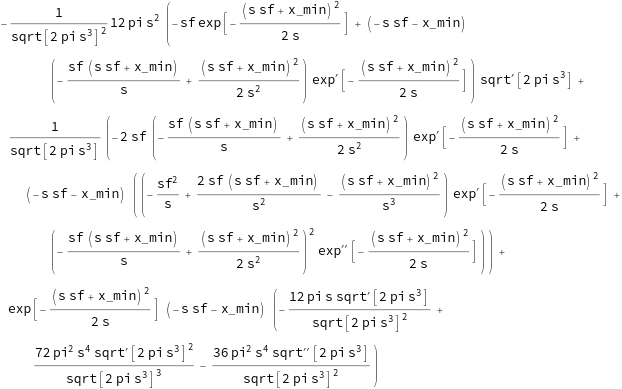

In [ ]:
def second_derivative(x_min, sf, s=24):
    part_1 = (-1/(np.sqrt(2*pi*s**3))**2) * 12*pi*s**2 * ( -sf * exp(-(s*sf + x_min)**2 / (2*s)) + (-s*sf - x_min) * ( -sf * (s*sf + x_min)/s + (s*sf + x_min)**2/(2*s) ) * exp(-(s*sf + x_min)**2 / (2*s)) ) * np.sqrt(2*pi*s**3)

    g1 = (1/(np.sqrt(2*pi*s**3)))
    g2 = (-sf*(s*sf + x_min)/s + (s*sf + x_min)**2 / (2*s**2)) * exp(-(s*sf + x_min)**2 / (2*s))
    g3 = (-sf**2/s + 2*sf*(s*sf + x_min)/(s**2) - (s*sf+x_min)**2/(s**3) ) * exp(-(s*sf + x_min)**2 / (2*s))
    g4 = (-sf*(s*sf + x_min)/s + (s*sf + x_min)**2 / (2*s**2))**2 * exp(-(s*sf + x_min)**2 / (2*s))
    part_2 = g1 * ( -2*sf * g2 + (-s*sf - x_min)*( g3 + g4 ) )

    part_3 = exp(-(s*sf + x_min)**2 / (2*s))*(-s*sf - x_min)*(-12*pi*s*np.sqrt(2*pi*s**3)/np.sqrt(2*pi*s**3)**2 + 72*(pi**2)*(s**4)*np.sqrt(2*pi*s**3)**2/np.sqrt(2*pi*s**3)**3 - 36*(pi**2)*(s**4)*np.sqrt(2*pi*s**3)/np.sqrt(2*pi*s**3)**2 )

    return part_1 + part_2 + part_3

In [ ]:
vaults_prob = [
    '0x0b6EB1255c0a6e43D35250A30763724A5d474902',
    '0xEe0d9208d059Cd33Ed716472a3e2914F31FA07D5',
    '0x7EE479bF664fE1aA5d0088D340452bCC8E1a10aF',
    '0xA25490bf76880d0cAc7A223dD02f935dd7f29B2B',
    '0x17667545b0FfD126924F238399aaa541de0e47bF',
    '0xD94CF5A83A385dca571b8eC37118C499c18a90B7',
    '0x73Fa3Ed3d54535210d6d1a2270C2051a5E210a0e',
    '0xD8A38f5100df108A1D58A84d6b9db808BC55f24D',
    '0xfD16B637d1668B94B730E157b88dd1f1f0Da74da',
    '0xdC2d916C77a5F5674072907A2A255AA1B632a73',
    '0x4A29FD74C7f6581422c880D92e472733eFfdFe26',
    '0x4aF8D22751C6205E410da9E8f84CCEC689C19239'
]

## liquidation table

In [ ]:
# --------------------------------- Liquidation ---------------------------------
import scipy.integrate as integrate

liq_df = pd.DataFrame( )

for vault in tqdm_notebook(grab_usr):
# for vault in tqdm_notebook(vaults_prob):

    '''KEEP THE LAST TIMESTAMP OF EACH DAY'''

    a = table_liq(vault)
    a["timestamp"] = a["timestamp"].astype("datetime64")
    a['tab_at_mn'] = a['tab']
    a['x_min'] = None
    a = a.groupby(a.timestamp.dt.date).last().reset_index(drop=True)

    for index, row in a.iterrows():
        date = 'year/month/day 23:59:59'
        midnight_date = date.replace('year', str(row.timestamp.year)).replace('month', str(row.timestamp.month)).replace('day', str(row.timestamp.day))
        time_diff = (pd.to_datetime(midnight_date, format='%Y/%m/%d %H:%M:%S') - row.timestamp).total_seconds()/(60*60)     # second -> hr

        # '%Y-%m-%d %H:%M:%S'
        date_mid = 'year-month-day 23:59:59'
        date_mid_2 = date_mid.replace('year', str(row.timestamp.year)).replace('month', str(row.timestamp.month)).replace('day', str(row.timestamp.day))

        # art with stability fee
        sf_t = get_stability_fee(row.timestamp)
        tab_at_mn = row.tab * (exp(sf_t * time_diff))
        a.at[index, 'tab_at_mn'] = tab_at_mn
        # print(f"\ntab at min = {tab_at_mn}, tab = {row.tab}, {sf_t * time_diff} ")   #######

        # x min
        r_min = get_collteral_ratio(row.timestamp)
        sf_midnight = get_stability_fee(date_mid_2)

        if row['ink']!= 0:
            x_min = np.float32(np.log((row['tab_at_mn'] * r_min)/(row['ink'])) / sigma * exp(sf_midnight * 24))
        else:
            x_min = np.inf
        a.at[index, 'x_min'] = x_min
        # print(f"x_min = {x_min}, ink = {row['ink']}")      #######

        # psi & var
        if a.at[index,'x_min'] <= 0:

            x = np.linspace(0, 24, num=100)
            x = x[1:]
            # y = [f(time, x_min, sf_midnight) for time in x]

            # psi = integrate.romberg(f, 0, 24, args = (a.at[index, 'x_min'], sf_midnight), tol=1e-8, rtol=1e-8)
            # psi = integrate.simpson(y, x, dx=1e-16)

            # psi = quad(f, 0, 24, args = (a.at[index, 'x_min'], sf_midnight))[0]
            psi = integrate_psi(a.at[index, 'x_min'], sf_midnight)

            n = 100
            error_eq = max([np.abs(second_derivative(x_min, sf_midnight, s_i))*(24-0)**3/(12*n**2) for s_i in x])

            if psi < 0:
            #     # x = np.linspace(0, 24, num=1000)
            #     # x = x[1:]
            #     # # y = [f(time, x_min, date_mid_2) for time in x]
            #     # # new_psi = integrate.trapezoid(y, x)

            #     n = 100
            #     error_eq = max([np.abs(second_derivative(x_min, sf_midnight, s_i))*(24-0)**3/(12*n**2) for s_i in x])

                print(f'\nvault = {vault}')
                print(f'date = {date_mid_2}')
                print(f'x_min = {x_min}, sf = {sf_midnight}')
                print(f'psi = {psi}')
            #     print(f"error = {error_eq}, error quad = {quad(f, 0, 24, args = (a.at[index, 'x_min'], sf_midnight))[1]}")
                print(f"{tab_at_mn}, {r_min}, {row['ink']}")

            #     if sf_t != sf_midnight:
            #         print('stability fee change!')
            #         print(sf_t, sf_midnight)

            a.at[index,'psi'] = psi
            a.at[index,'var'] = psi * (1 - psi)
            a.at[index,'err_eq'] = error_eq
        else:
            a.at[index,'psi'] = None
            a.at[index,'var'] = None
            a.at[index,'err_eq'] = None

    liq_df = liq_df.append(a, ignore_index=True)
    liq_df = liq_df[liq_df['tab_at_mn']>0]

  0%|          | 0/2803 [00:00<?, ?it/s]

In [ ]:
liq_df2 = liq_df.copy()
liq_df2["timestamp"] = liq_df2["timestamp"].astype("datetime64").dt.date

a = liq_df2[~liq_df2['x_min'].isin([np.inf, -np.inf])]
liq_df2 = a[~a['x_min'].isnull() & ~a['psi'].isnull()]

In [ ]:
table = liq_df2[(liq_df2['x_min'] > -0.011) & (liq_df2['x_min'] < 0.011)].reset_index(drop=True)
table

,usr,fn_name,timestamp,dart,dink_dai,dtab,wad,art,ink,tab,ex_rate,rate,collateral ratio,tab_at_mn,x_min,psi,var,err_eq
0,0xdC2d916C77a5F5674072907A2A255AA1B632a73,frob,2020-07-28,20.773657,31.787376,21.19,NaN,20.773657,31.787376,21.190000,317.873759,1.020042,150.011212,21.190000,-0.003788,1.0,0.0,174.539333
1,0xD8A38f5100df108A1D58A84d6b9db808BC55f24D,frob,2021-07-19,0.000000,32731.185247,0.00,NaN,108166.895456,166559.812588,111036.114737,1818.399180,1.050798,150.005080,111038.472889,-0.001716,1.0,0.0,76.583349
2,0x17667545b0FfD126924F238399aaa541de0e47bF,frob,2019-12-15,0.000000,-14.092000,0.00,NaN,4789.583776,7191.484099,4793.723167,140.920000,1.003389,150.018761,4794.067024,-0.006339,1.0,0.0,287.121009
3,0x73Fa3Ed3d54535210d6d1a2270C2051a5E210a0e,frob,2020-06-23,31.578458,48.325356,32.21,NaN,31.578458,48.325356,32.210000,241.626778,1.019999,150.032150,32.210000,-0.010861,1.0,0.0,500.440473
4,0x0b6EB1255c0a6e43D35250A30763724A5d474902,frob,2020-07-31,5350.809694,8187.086734,5458.05,NaN,5350.809694,8187.086734,5458.050000,337.097490,1.020042,150.000215,5458.050000,-0.000073,1.0,0.0,3.346771
5,0x4aF8D22751C6205E410da9E8f84CCEC689C19239,frob,2020-06-06,31.460811,48.138000,32.09,NaN,31.460811,48.138000,32.090000,240.690000,1.019999,150.009349,32.090000,-0.003158,1.0,0.0,145.530510
6,0xA25490bf76880d0cAc7A223dD02f935dd7f29B2B,frob,2020-06-11,0.000000,-118.413187,0.00,NaN,1246.390263,1907.147664,1271.258308,233.355714,1.019999,150.020468,1271.258308,-0.006915,1.0,0.0,318.613407
7,0x7EE479bF664fE1aA5d0088D340452bCC8E1a10aF,frob,2020-11-22,60.589460,0.000000,61.99,NaN,1037.996514,1593.000000,1061.990000,531.000000,1.023115,150.001412,1062.008880,-0.000477,1.0,0.0,19.489287
8,0xfD16B637d1668B94B730E157b88dd1f1f0Da74da,frob,2019-11-20,149.106664,223.833300,149.22,NaN,149.106664,223.833300,149.220000,174.325000,1.000760,150.002211,149.221466,-0.000747,1.0,0.0,29.479557
9,0x4A29FD74C7f6581422c880D92e472733eFfdFe26,frob,2020-03-09,0.000000,366.111000,0.00,NaN,2385.190592,3600.383397,2400.000000,203.395000,1.018215,150.015975,2400.225647,-0.005398,1.0,0.0,239.010639


In [ ]:
for index, row in table.iterrows():
    date = 'year-month-day 23:59:59'
    midnight_date = date.replace('year', str(pd.to_datetime(row.timestamp).year)).replace('month', str(pd.to_datetime(row.timestamp).month)).replace('day', str(pd.to_datetime(row.timestamp).day))
    print(f'\n{row.x_min}, {get_stability_fee(midnight_date)}')


-0.003787947, 0.0

-0.0017163062, 2.260575882928606e-06

-0.006338712, 4.477260590496357e-06

-0.010860853, 0.0

-7.263341e-05, 0.0

-0.0031583814, 0.0

-0.006914725, 0.0

-0.0004772203, 2.260575882928606e-06

-0.0007472345, 4.477260590496357e-06

-0.005397991, 8.785545304146325e-06

-0.0092727905, 0.0

-0.0008749044, 4.477260590496357e-06

-5.0602368e-05, 0.0


In [ ]:
# index          x_min        psi (from Mathematica)
# 504         -0.003788       0.999383
# 764         -0.001716       0.999712
# 2423        -0.006339       0.998950
# 4299        -0.010861       0.998231
# 5800        -0.000073       0.999988
# 7611        -0.003158       0.999486
# 8125        -0.006915       0.998874
# 10910       -0.000477       0.999913
# 13455       -0.000747       0.999861
# 14670       -0.005398       0.999087
# 15147       -0.009273       0.998490
# 16667       -0.000875       0.999840
# 17432       -5.0602368e-05  0.999992

idx_list = [504, 764, 2423, 4299, 5800, 7611, 8125, 10910, 13455, 14670, 15147, 16667, 17432]
true_psi = [0.999383, 0.999712, 0.99895, 0.998231, 0.999988, 0.999486, 0.998874, 0.999913, 0.999861, 0.999087, 0.99849, 0.99984, 0.999992]

In [ ]:
for i, idx in enumerate(idx_list):
    liq_df2.at[idx,'psi'] = true_psi[i]

In [ ]:
for i, idx in enumerate(idx_list):
    liq_df2.at[idx, 'var'] = true_psi[i] * (1 - true_psi[i])

In [ ]:
liq_df2[(liq_df2['x_min'] > -0.011) & (liq_df2['x_min'] < 0.011)]

,usr,fn_name,timestamp,dart,dink_dai,dtab,wad,art,ink,tab,ex_rate,rate,collateral ratio,tab_at_mn,x_min,psi,var,err_eq
504,0xdC2d916C77a5F5674072907A2A255AA1B632a73,frob,2020-07-28,20.773657,31.787376,21.19,NaN,20.773657,31.787376,21.190000,317.873759,1.020042,150.011212,21.190000,-0.003788,0.999383,0.000617,174.539333
764,0xD8A38f5100df108A1D58A84d6b9db808BC55f24D,frob,2021-07-19,0.000000,32731.185247,0.00,NaN,108166.895456,166559.812588,111036.114737,1818.399180,1.050798,150.005080,111038.472889,-0.001716,0.999712,0.000288,76.583349
2423,0x17667545b0FfD126924F238399aaa541de0e47bF,frob,2019-12-15,0.000000,-14.092000,0.00,NaN,4789.583776,7191.484099,4793.723167,140.920000,1.003389,150.018761,4794.067024,-0.006339,0.998950,0.001049,287.121009
4299,0x73Fa3Ed3d54535210d6d1a2270C2051a5E210a0e,frob,2020-06-23,31.578458,48.325356,32.21,NaN,31.578458,48.325356,32.210000,241.626778,1.019999,150.032150,32.210000,-0.010861,0.998231,0.001766,500.440473
5800,0x0b6EB1255c0a6e43D35250A30763724A5d474902,frob,2020-07-31,5350.809694,8187.086734,5458.05,NaN,5350.809694,8187.086734,5458.050000,337.097490,1.020042,150.000215,5458.050000,-0.000073,0.999988,0.000012,3.346771
7611,0x4aF8D22751C6205E410da9E8f84CCEC689C19239,frob,2020-06-06,31.460811,48.138000,32.09,NaN,31.460811,48.138000,32.090000,240.690000,1.019999,150.009349,32.090000,-0.003158,0.999486,0.000514,145.530510
8125,0xA25490bf76880d0cAc7A223dD02f935dd7f29B2B,frob,2020-06-11,0.000000,-118.413187,0.00,NaN,1246.390263,1907.147664,1271.258308,233.355714,1.019999,150.020468,1271.258308,-0.006915,0.998874,0.001125,318.613407
10910,0x7EE479bF664fE1aA5d0088D340452bCC8E1a10aF,frob,2020-11-22,60.589460,0.000000,61.99,NaN,1037.996514,1593.000000,1061.990000,531.000000,1.023115,150.001412,1062.008880,-0.000477,0.999913,0.000087,19.489287
13455,0xfD16B637d1668B94B730E157b88dd1f1f0Da74da,frob,2019-11-20,149.106664,223.833300,149.22,NaN,149.106664,223.833300,149.220000,174.325000,1.000760,150.002211,149.221466,-0.000747,0.999861,0.000139,29.479557
14670,0x4A29FD74C7f6581422c880D92e472733eFfdFe26,frob,2020-03-09,0.000000,366.111000,0.00,NaN,2385.190592,3600.383397,2400.000000,203.395000,1.018215,150.015975,2400.225647,-0.005398,0.999087,0.000912,239.010639


In [ ]:
# liq_df2.to_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/liq_df2_update_psi.csv')

In [ ]:
liq_df2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/liq_df2_update_psi.csv').drop(columns=['Unnamed: 0'])
liq_df2['timestamp'] = liq_df2['timestamp'].astype({ 'timestamp': 'datetime64' })

In [ ]:
liq_df2

,usr,fn_name,timestamp,dart,dink_dai,dtab,wad,art,ink,tab,ex_rate,rate,collateral ratio,tab_at_mn,x_min,psi,var,err_eq
0,0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa,frob,2020-08-13,490.175951,1280.508725,500.00000,NaN,490.175951,1280.508725,500.00000,426.836242,1.020042,256.101745,500.000000,-27.109562,3.135162e-08,3.135162e-08,0.279190
1,0x1D3E2510489c6E17F31D07CE0E584a632D1DF7Fa,frob,2020-08-14,-470.568913,0.000000,-480.00000,NaN,19.607038,1280.508725,20.00000,426.681250,1.020042,6402.543623,20.000000,-190.235140,0.000000e+00,0.000000e+00,0.000000
2,0x66e7316D190ed9cE8D30bAECAE900415ec59c7Bd,frob,2020-02-08,108.708515,285.362406,110.00000,NaN,108.708515,285.362406,110.00000,224.694808,1.011880,259.420369,110.000920,-27.768593,1.443098e-08,1.443098e-08,0.134635
3,0x66e7316D190ed9cE8D30bAECAE900415ec59c7Bd,frob,2020-02-11,35.162205,0.000000,35.60000,NaN,35.162205,103.308411,35.60000,223.416907,1.012451,290.192166,35.602800,-33.449745,8.619103e-12,8.619103e-12,0.000116
4,0xAb7cFd3DDcC7b10C371b2c92FeA38CAB05d12CEF,frob,2020-02-27,260.859123,0.000000,265.00000,NaN,1048.362546,3196.512171,1065.00000,229.140657,1.015874,300.141988,1065.081795,-35.158573,7.142865e-13,7.142865e-13,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19923,0x60D463BC4787CD9A117C0d09F1e7B8C63B364479,frob,2019-12-04,159.875702,335.787429,160.23189,NaN,159.875702,335.787429,160.23189,145.875000,1.002228,209.563421,160.239595,-16.948030,5.412128e-04,5.409199e-04,1964.753270
19924,0x60D463BC4787CD9A117C0d09F1e7B8C63B364479,frob,2019-12-17,368.656052,0.000000,370.00000,NaN,528.531754,1103.547429,530.23189,127.960000,1.003646,208.125435,530.248851,-16.599052,7.034049e-04,7.029101e-04,2455.925900
19925,0xEF648c99AF1257DFA785813Cd2abf7d63b0e3e23,frob,2021-05-05,4803.511236,11455.356000,5000.00000,NaN,4803.511236,11455.356000,5000.00000,3471.320000,1.040905,229.107120,5000.112266,-21.467957,1.175403e-05,1.175389e-05,66.784633
19926,0xEF648c99AF1257DFA785813Cd2abf7d63b0e3e23,frob,2021-05-19,3834.958915,0.000000,4000.00000,NaN,8638.470151,22893.176400,9000.00000,2776.170000,1.043036,254.368627,9000.280682,-26.769371,4.648762e-08,4.648762e-08,0.403973


In [ ]:
liq_df2[(liq_df2['x_min'] > -0.011) & (liq_df2['x_min'] < 0.011)]

,usr,fn_name,timestamp,dart,dink_dai,dtab,wad,art,ink,tab,ex_rate,rate,collateral ratio,tab_at_mn,x_min,psi,var,err_eq
504,0xdC2d916C77a5F5674072907A2A255AA1B632a73,frob,2020-07-28,20.773657,31.787376,21.19,NaN,20.773657,31.787376,21.190000,317.873759,1.020042,150.011212,21.190000,-0.003788,0.999383,0.000617,174.539333
764,0xD8A38f5100df108A1D58A84d6b9db808BC55f24D,frob,2021-07-19,0.000000,32731.185247,0.00,NaN,108166.895456,166559.812588,111036.114737,1818.399180,1.050798,150.005080,111038.472889,-0.001716,0.999712,0.000288,76.583349
2423,0x17667545b0FfD126924F238399aaa541de0e47bF,frob,2019-12-15,0.000000,-14.092000,0.00,NaN,4789.583776,7191.484099,4793.723167,140.920000,1.003389,150.018761,4794.067024,-0.006339,0.998950,0.001049,287.121009
4299,0x73Fa3Ed3d54535210d6d1a2270C2051a5E210a0e,frob,2020-06-23,31.578458,48.325356,32.21,NaN,31.578458,48.325356,32.210000,241.626778,1.019999,150.032150,32.210000,-0.010861,0.998231,0.001766,500.440473
5800,0x0b6EB1255c0a6e43D35250A30763724A5d474902,frob,2020-07-31,5350.809694,8187.086734,5458.05,NaN,5350.809694,8187.086734,5458.050000,337.097490,1.020042,150.000215,5458.050000,-0.000073,0.999988,0.000012,3.346771
7611,0x4aF8D22751C6205E410da9E8f84CCEC689C19239,frob,2020-06-06,31.460811,48.138000,32.09,NaN,31.460811,48.138000,32.090000,240.690000,1.019999,150.009349,32.090000,-0.003158,0.999486,0.000514,145.530510
8125,0xA25490bf76880d0cAc7A223dD02f935dd7f29B2B,frob,2020-06-11,0.000000,-118.413187,0.00,NaN,1246.390263,1907.147664,1271.258308,233.355714,1.019999,150.020468,1271.258308,-0.006915,0.998874,0.001125,318.613407
10910,0x7EE479bF664fE1aA5d0088D340452bCC8E1a10aF,frob,2020-11-22,60.589460,0.000000,61.99,NaN,1037.996514,1593.000000,1061.990000,531.000000,1.023115,150.001412,1062.008880,-0.000477,0.999913,0.000087,19.489287
13455,0xfD16B637d1668B94B730E157b88dd1f1f0Da74da,frob,2019-11-20,149.106664,223.833300,149.22,NaN,149.106664,223.833300,149.220000,174.325000,1.000760,150.002211,149.221466,-0.000747,0.999861,0.000139,29.479557
14670,0x4A29FD74C7f6581422c880D92e472733eFfdFe26,frob,2020-03-09,0.000000,366.111000,0.00,NaN,2385.190592,3600.383397,2400.000000,203.395000,1.018215,150.015975,2400.225647,-0.005398,0.999087,0.000912,239.010639


# Read all data

In [14]:
# ---------- read all data ----------

sigma = 0.019732503015237123

# vat_E
vat_E = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E.csv').drop(columns=['Unnamed: 0'])
vat_E['timestamp'] = vat_E['timestamp'].astype({ 'timestamp': 'datetime64' })

# ETH/DAI rate
daieth2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/daieth2.csv').drop(columns=['Unnamed: 0'])
daieth2['timestamp'] = daieth2['timestamp'].astype({ 'timestamp': 'datetime64' })

# stability fee rate
sf_rate_pd = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/sf_rate_pd.csv').drop(columns=['Unnamed: 0'])
sf_rate_pd['timestamp'] = sf_rate_pd['timestamp'].astype({ 'timestamp': 'datetime64' })

# vat_E2
vat_E2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/vat_E2.csv').drop(columns=['Unnamed: 0'])
vat_E2['timestamp'] = vat_E2['timestamp'].astype({ 'timestamp': 'datetime64' })

# see shape
print(f'vat_E shape = {vat_E.shape} \ndaieth2 shape = {daieth2.shape} \nsf_rate_pd shape = {sf_rate_pd.shape}')

# group grab users
ethA = vat_E.copy()
ethA_default = filter_ethA_data(vat_E)
grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())

# liquidation table
liq_df2 = pd.read_csv('/content/drive/MyDrive/1_thesis/1_working/data_final/liq_df2_update_psi.csv').drop(columns=['Unnamed: 0'])
liq_df2['timestamp'] = liq_df2['timestamp'].astype({ 'timestamp': 'datetime64' })

# df_count
df_count = liq_df2.groupby(by=liq_df2['timestamp']).size().reset_index(name='counts').sort_values(by='timestamp')

vat_E shape = (542670, 10) 
daieth2 shape = (300833, 3) 
sf_rate_pd shape = (300833, 3)


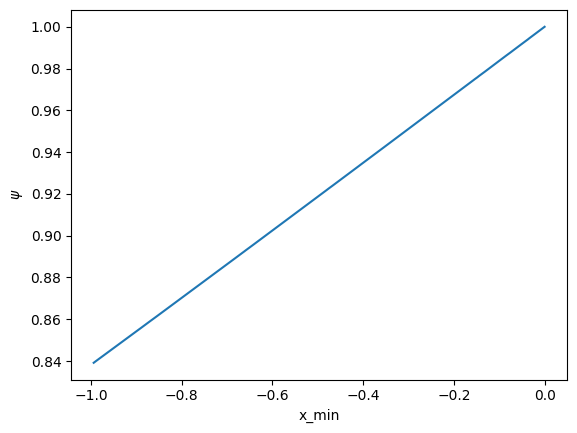

In [15]:
plot_x_min = liq_df2[liq_df2['x_min'] > -1.0][['x_min', 'psi']].sort_values(by='x_min')['x_min']
plot_psi = liq_df2[liq_df2['x_min'] > -1.0][['x_min', 'psi']].sort_values(by='x_min')['psi']

plt.plot(plot_x_min, plot_psi)
plt.xlabel('x_min')
plt.ylabel(r"$\psi$");

In [16]:
liq_df2[liq_df2['usr']=='0x4f3f9EAaad72d80017448E9211Ce03bC909d735e']

,usr,fn_name,timestamp,dart,dink_dai,dtab,wad,art,ink,tab,ex_rate,rate,collateral ratio,tab_at_mn,x_min,psi,var,err_eq
6191,0x4f3f9EAaad72d80017448E9211Ce03bC909d735e,frob,2019-12-23,3983.055413,11119.688593,4000.0,NaN,3983.055413,11119.688593,4000.0,132.377245,1.004254,277.992215,4000.281903,-31.26943,1.738508e-10,1.738508e-10,0.002043


# Plot graph

In [ ]:
liq_df2.shape[0], liq_df2[liq_df2['x_min'] > 0 ].shape[0],

(19928, 0)

In [ ]:
# check x_min < 0 NaN
len(liq_df2[liq_df2['x_min'] > 0]),len(liq_df2[liq_df2['x_min'].isnull()]),len(liq_df2[liq_df2['psi'].isnull()]),len(liq_df2[liq_df2['var'].isnull()])

(0, 0, 0, 0)

scale of x_min (-2042.418,-5.0602368e-05)


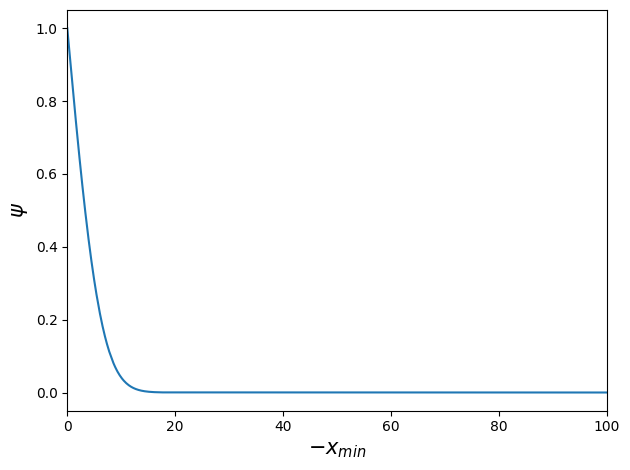

In [ ]:
# plot psi x_min
n_inf_x_min = liq_df2[~liq_df2['x_min'].isin([np.inf, -np.inf])].sort_values(by=['x_min'])
print(f"scale of x_min ({n_inf_x_min['x_min'].min()},{n_inf_x_min['x_min'].max()})")
plt.plot(list(-n_inf_x_min["x_min"]), list( n_inf_x_min["psi"]))
plt.xlabel(r'$-x_{min}$',size = 15)
plt.ylabel(r"$\psi$",size = 15)
# plt.grid(True)
plt.xlim((0,100))
plt.tight_layout()
plt.show()

In [ ]:
n_inf_x_min[n_inf_x_min['psi'] < 0]

,usr,fn_name,timestamp,dart,dink_dai,dtab,wad,art,ink,tab,ex_rate,rate,collateral ratio,tab_at_mn,x_min,psi,var,err_eq


scale of x_min (-2042.418,-5.0602368e-05)


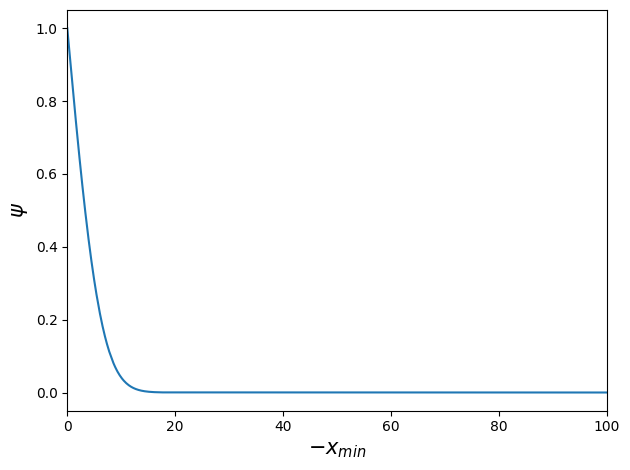

In [ ]:
# plot psi x_min
n_inf_x_min = liq_df2[~liq_df2['x_min'].isin([np.inf, -np.inf])].sort_values(by=['x_min'])
print(f"scale of x_min ({n_inf_x_min['x_min'].min()},{n_inf_x_min['x_min'].max()})")
plt.plot(list(-n_inf_x_min["x_min"]), list( n_inf_x_min["psi"]))
plt.xlabel(r'$-x_{min}$',size = 15)
plt.ylabel(r"$\psi$",size = 15)
# plt.grid(True)
plt.xlim((0,100))
plt.tight_layout()
plt.show()

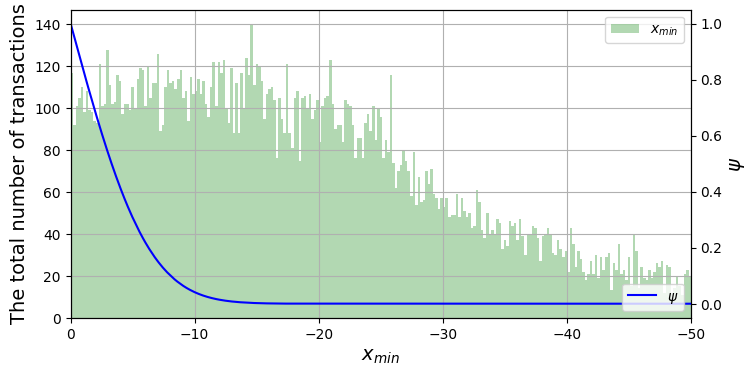

In [ ]:
fig, ax1 = plt.subplots(1,1,  figsize=(8,4) )
n_inf_x_min['x_min'].hist(ax=ax1, bins=10000, color='green',alpha = 0.3, label = r'$x_{min}$')
ax2 = ax1.twinx()
n_inf_x_min.plot.line(ax=ax2,x='x_min', y='psi', color='blue', label = r'$\psi$')
ax1.set_xlim((0,-50))
ax2.set_xlim((0,-50))

ax2.set_ylabel(r'$\psi$', fontsize=14) # from theory
ax1.set_ylabel(r'The total number of transactions', fontsize=14) # from actual data
ax1.set_xlabel(r'$x_{min}$', fontsize=14)
locs = ["upper right", "lower right"]
ax1.legend(loc=locs[0])
ax2.legend(loc=locs[1])
plt.show()

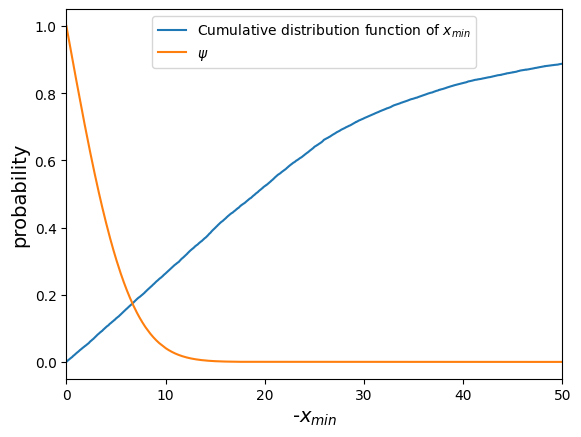

In [ ]:
#sort data
data = list(n_inf_x_min['x_min'])
data = [-x for x in data]
x = np.sort(data)

#calculate CDF values
y = 1. * np.arange(len(data)) / (len(data) - 1)

#plot CDF
plt.plot(x, y, label = r'Cumulative distribution function of $x_{min}$')
plt.plot(list(-n_inf_x_min["x_min"]), list( n_inf_x_min["psi"]), label = r'$\psi$')
plt.xlabel(r'$-x_{min}$',size = 14)
plt.ylabel("probability",size = 14)
plt.xlim(-0.01,50)
plt.xlabel(r'-$x_{min}$')
plt.legend()
plt.show()

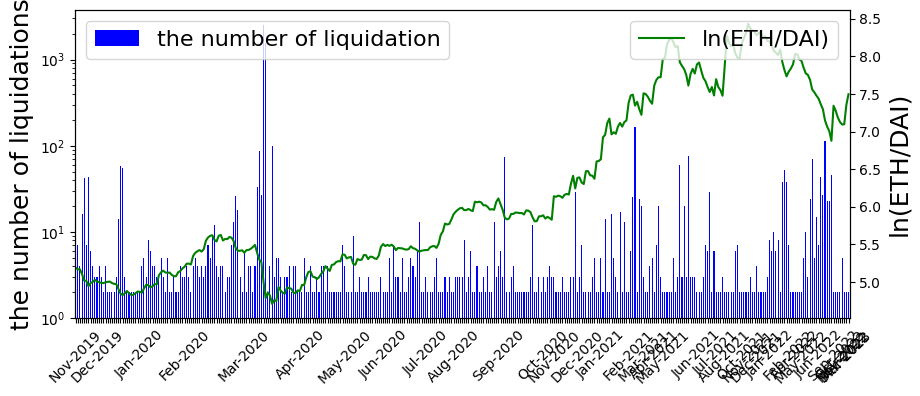

In [ ]:
# both y axis are in log
daieth_gp = daieth2.copy()
daieth_gp["timestamp"] = daieth_gp["timestamp"].astype("datetime64")
daieth_gp['dai/eth']= np.log(daieth_gp['dai/eth']) # TAKE log

a = vat_E[vat_E.fn_name == 'grab'].drop(['ilk', 'usr','wad','src','dart','dink','rate'], axis=1)
a.timestamp = a.timestamp.astype("datetime64")
a.timestamp = a.timestamp.dt.date
daieth_gp.timestamp = daieth_gp.timestamp.dt.date
daieth_gp_group = daieth_gp.groupby(['timestamp']).mean().reset_index(level=0)
b = a.groupby('timestamp').count().reset_index(level=['timestamp']).rename(columns={'fn_name': 'Count'})


merge_df = pd.merge(b, daieth_gp_group, on='timestamp', how='inner')
merge_df[merge_df['Count'] == merge_df['Count'].max()]

merge_df['M-Y-Date'] = pd.to_datetime(merge_df['timestamp'])
merge_df['M-Y-Date']= merge_df['M-Y-Date'].dt.to_period('M')

new = str()
list_date = []
for j in list(merge_df['M-Y-Date'] ):
    if j == new:
        list_date.append(" ")
    else:
        list_date.append(j.strftime('%b-%Y'))
    new = j

###################################################

fig, ax1 = plt.subplots(1,1,figsize=(10, 4))
merge_df['Count'].plot(ax=ax1, color='blue',kind='bar',log=True, label = 'the number of liquidation')
ax2 = ax1.twinx()
merge_df['dai/eth'].plot(ax=ax2, color='green', label = 'ln(ETH/DAI)')

ax1.set_ylabel('the number of liquidations', fontsize=18)
ax2.set_ylabel('ln(ETH/DAI)', fontsize=18)

list_date_replace = [sub.replace('Sep-2021', '').replace('Mar-2022','') for sub in list_date] # due to x label is overlapping
ax1.set_xticklabels(list_date_replace,rotation=45, fontsize=10)
ax2.set_xticklabels(list_date_replace,rotation=45, fontsize=10)

ax1.legend(loc="upper left", fontsize=16)
ax2.legend(loc="upper right", fontsize=16)
plt.show()


In [ ]:
abs(liq_df2.timestamp.min()-liq_df2.timestamp.max()).days

1228

# Optimization -- CVXPY

## CVXPY

objective function:

$$ \|\vec{a}\|_1 \rightarrow max \,\, \vec{a} $$


constraints:

$$
\begin{gathered}
\vec{a}^{T} K \vec{a} \leq \sigma^{2} \cdot\|\vec{a}\|_{1}^{2} \quad \quad (\|L^T \vec{a}\|_2 \leq σ \mathbb{1}^T \vec{a})\\
\overrightarrow{0} \leq \vec{a} \leq \vec{A}
\end{gathered}
$$


In [ ]:
import cvxpy.atoms.norm as norm

# sigma2 = 0.00198/1.27                                     # Forex data -Yatipa

sigma2 = 0.005807199353432736 / 1.662462247251338         # updated Forex data
sigma = np.round(np.sqrt(sigma2), 4)
print(f'sigma2 = {sigma2} \nsigma = {sigma}')

# All timestamps
duration_date = sorted(list(liq_df2['timestamp'].unique()))
print(f'All days = {len(duration_date)} \nfrom {min(duration_date)} to {max(duration_date)}')

# def margine(vector_a, sigma2, covariance_matrix):
#     return sigma2 * np.linalg.norm((vector_a), ord=1)**2 - ((vector_a @ covariance_matrix) @ vector_a)

# def margine(vector_a, sigma2, covariance_matrix):
#     return sigma2 * cp.atoms.norm1(vector_a)**2 - ((vector_a @ covariance_matrix) @ vector_a)

def ub_constraint(vector_a, A):
    return cp.sum(vector_a) - cp.sum(A)

def violate(value):
    return 0 if value >= 0 else value

sigma2 = 0.003493131566165893 
sigma = 0.0591
All days = 1125 
from 2019-11-18T00:00:00.000000000 to 2023-03-30T00:00:00.000000000


Sigma | Fraction (metaheuristic) | Note
--- | --- | ---
0.03948487201587763     |   0.6911321947473391  | Forex data -Yatipa
0.005807199353432736    |   0.5539540198292338  | max cov.
0.0591                  |  0.7326291938817298   | approx(np.sqrt(max cov./factor))
0.07620498247117924      |   0.7629523109955503  | np.sqrt(max cov.)
0.1                     |   0.8001144347341658  | test


<br>

From updated Forex data (match date with vat_E)  <br>
**max cov.** == max covariance from Forex (Discreat Alg.)  <br>
**factor** == (Minimum) Reduction factor (Discreat Alg.)  <br>

**Approx**: A common cause is having too tight a numerical tolerance or having badly scaled data (i.e., the dynamic range of the floats in your program is too large).

In [ ]:
tokenized_volume_meta_cvxpy = []
margines_cvxpy = []
tokenizations_cvxpy = []
frac_tokenizations_cvxpy = []
vol_A_meta_cvxpy = []
vol_sum_A_cvxpy = []

norm_diff = []
norm_K = []
norm_LLT = []
real_K = []

sigma2 = 0.005807199353432736 / 1.662462247251338         # updated Forex data
sigma = np.round(np.sqrt(sigma2), 4)

def margine(vector_a, covariance_matrix, sigma2=sigma2):
      assets_number = len(vector_a)
      assert sigma2 > 0, "Required sigma2 > 0"
    #   print(np.shape(covariance_matrix), (assets_number, assets_number))
      assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
      return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2   # np.max(vector_a)**2

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i, (p_A, x_A) in enumerate(zip(list(table['psi']), list(table['x_min']))):
        for j, (p_B, x_B) in enumerate(zip(list(table['psi']), list(table['x_min']))):
            K[i, j] = p_B * (1 - p_A) if x_A > x_B else p_A * (1 - p_B)

    # symmetric covariance
    K = 1/2 * (K + K.T)
    real_K.append(K)

    # K = L @ L.T
    u, s, vh = np.linalg.svd(K)
    L = u @ np.sqrt(np.diag(s))
    norm_diff.append(np.linalg.norm(K - L @ L.T, ord=2))
    norm_K.append(np.linalg.norm(K , ord=2))
    norm_LLT.append(np.linalg.norm(L @ L.T, ord=2))

    a = cp.Variable(K.shape[0])
    f_t = np.ones(K.shape[0])
    zero_cond = np.zeros(K.shape[0]).T

    objective = cp.Maximize(f_t.T @ a)
    soc_constraints = [ cp.SOC( sigma*(f_t.T @ a) , L.T @ a ) ]
    prob = cp.Problem(objective,
                      soc_constraints + [norm(L.T @ a, 2) - sigma*(f_t.T @ a) <= 0] + [ a >= zero_cond ] + [ a <= A ] )
    prob.solve(feastol=1e-36)

    tokenized_volume_meta_cvxpy.append(np.sum(a.value))
    margines_cvxpy.append(margine(a.value, K, sigma2))
    tokenizations_cvxpy.append(a.value)

    vol_A_meta_cvxpy.append(A)
    vol_sum_A_cvxpy.append(np.sum(A))

    frac_cvxpy = np.sum(a.value)/ np.sum(A)
    frac_tokenizations_cvxpy.append(frac_cvxpy)

1125it [00:43, 25.83it/s]


In [ ]:
list_margine_in_range = []
list_idx = []
for i, margine in enumerate(margines_cvxpy):
    if margine <= 0:
        list_idx.append(i)
        list_margine_in_range.append(margine)

print(len(list_idx), len(list_margine_in_range))
len(list_margine_in_range)/1125

1115 1115


0.9911111111111112

In [ ]:
for i, margin in enumerate(margines_cvxpy):
    if margin > 0:
        print(margin)

4.153758821387738e-22
1.443844529517148e-21
1.5020088206404846e-21
6.153737161898853e-22
4.524003976796366e-22
3.8939032138097835e-24
3.1185561242127482e-21
6.302092693444207e-21
1.1229814489630804e-20
3.468448541075134e-24


In [ ]:
min(frac_tokenizations_cvxpy), max(frac_tokenizations_cvxpy)

(6.85311433352678e-17, 1.0)

Tokenized fraction:  0.6569465817866758
the number of fraction > 1: 0 numbers
----------
Tokenized fraction (avg):  0.7326291934973336


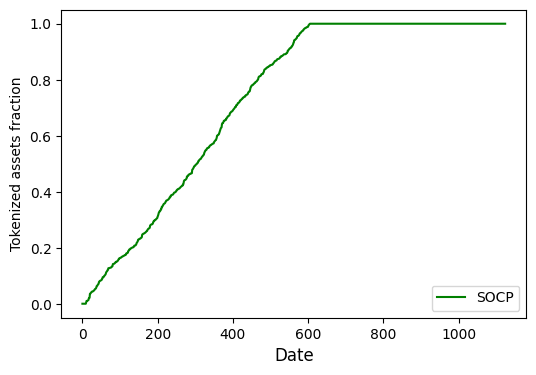

In [ ]:
liq_df_3 = liq_df2[liq_df2['timestamp'].isin(duration_date)]
time_tab = liq_df_3.groupby(by=liq_df_3['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

sumt_cvxpy = 0
for k in range(len(tokenizations_cvxpy)):
  sumt_cvxpy += np.sum(tokenizations_cvxpy[k])

print("Tokenized fraction: ", sumt_cvxpy / np.sum(time_tab['tab_at_mn']))
# print("Tokenized fraction: ", np.sum(tokenized_volume_meta) / np.sum(vol_sum_A))
print(f"the number of fraction > 1: {len([x for x in frac_tokenizations_cvxpy if (x>1)])} numbers")

## metaheuristic
print('-' * 10)
print("Tokenized fraction (avg): ", np.sum([x for x in frac_tokenizations_cvxpy if (x<=1)]) / len([x for x in frac_tokenizations_cvxpy if (x<=1)]))

####################################################################################################################################

fig = plt.figure(figsize=(6, 4))
plt.plot(np.sort([x for x in frac_tokenizations_cvxpy if (x<=1)]), 'g',label = "SOCP")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=10)
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np

print(np.finfo(float).eps)
print(np.finfo(np.float32).eps)

2.220446049250313e-16
1.1920929e-07


## Check norm -- for CVXPY

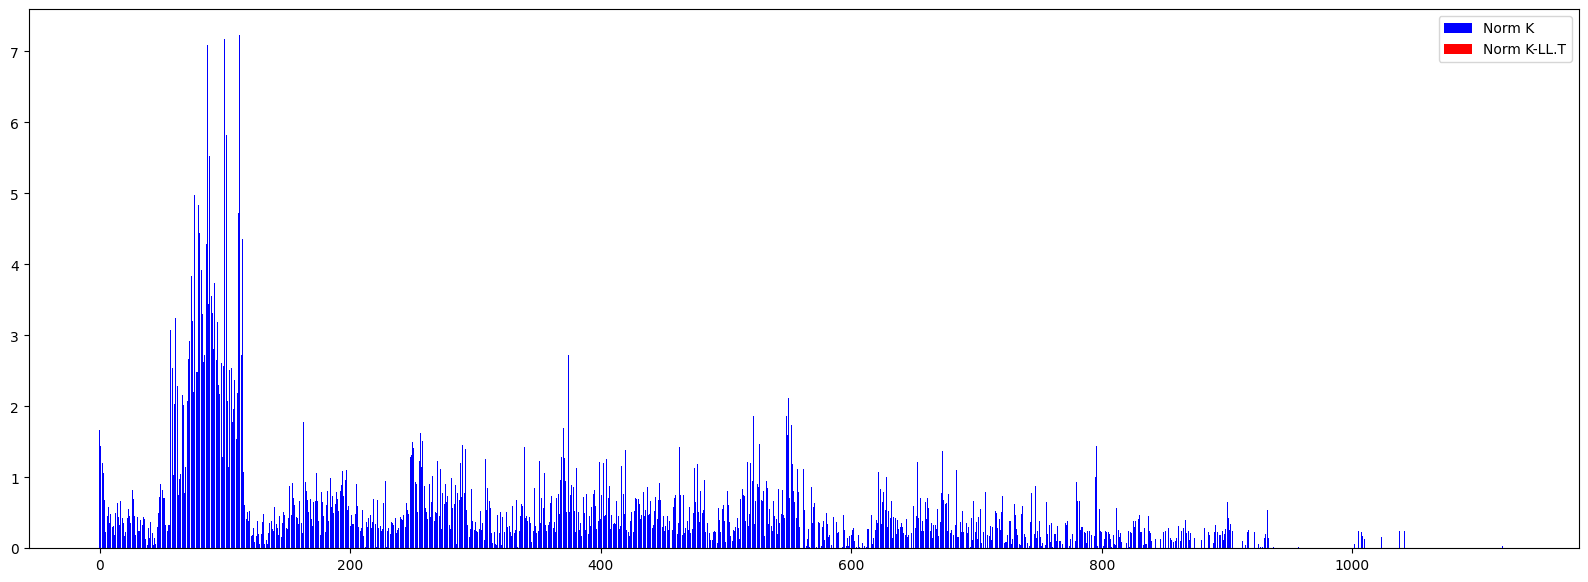

In [ ]:
x_lim = range(0, len(norm_K))

fig = plt.subplots(figsize =(20, 7))
plt.bar(x_lim, norm_K, label='Norm K', color='b')
plt.bar(x_lim, norm_diff, label='Norm K-LL.T', color='r')
plt.legend()
plt.show()

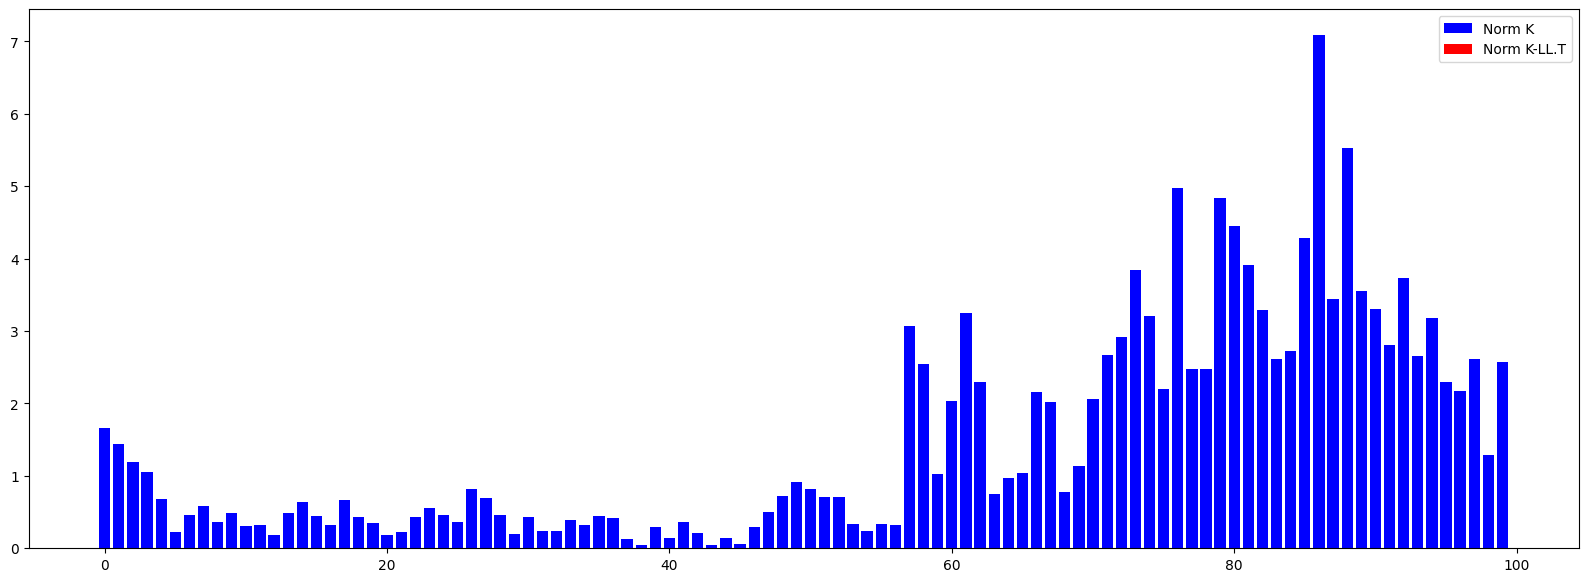

In [ ]:
x_lim = range(0, len(norm_K))
fig = plt.subplots(figsize =(20, 7))
plt.bar(x_lim[0:100], norm_K[0:100], label='Norm K', color='b')
plt.bar(x_lim[0:100], norm_diff[0:100], label='Norm K-LL.T', color='r')
plt.legend()
plt.show()

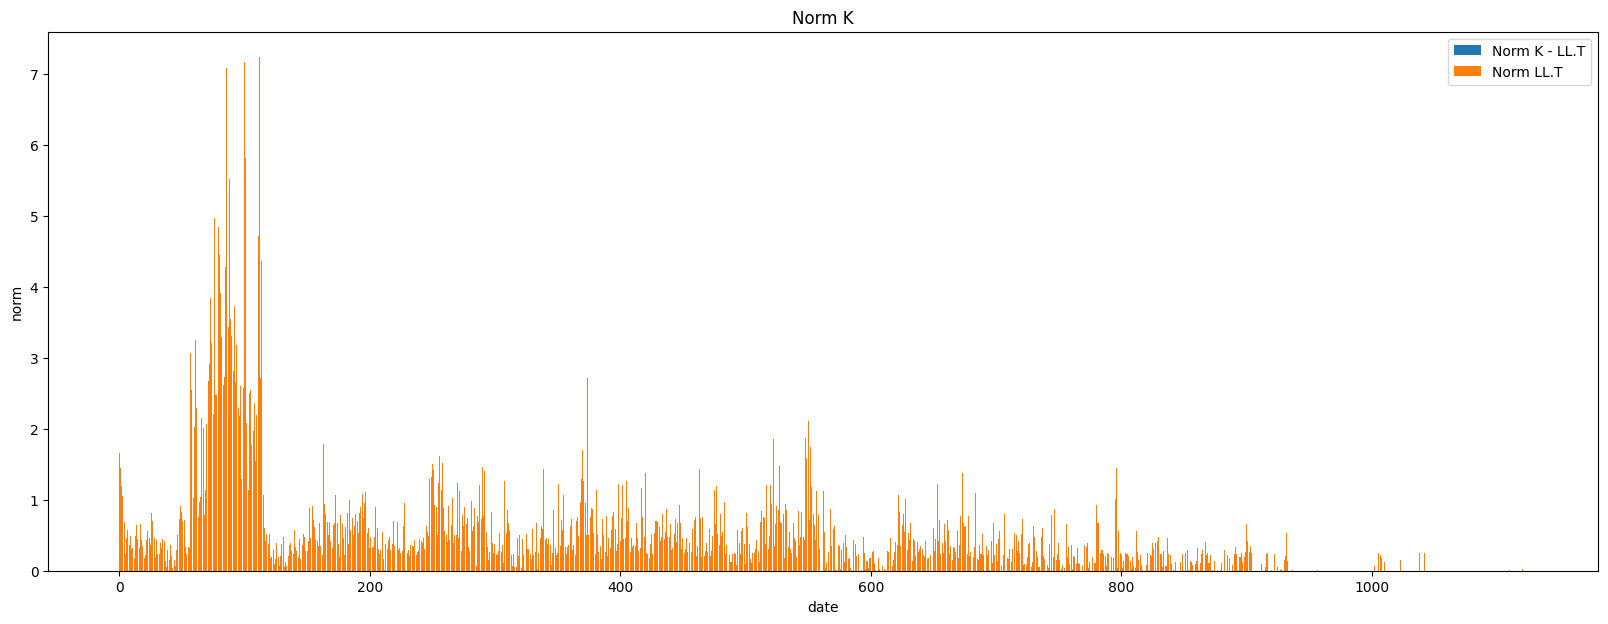

In [ ]:
x_lim = range(0, len(norm_K))
fig = plt.subplots(figsize =(20, 7))
plt.bar(x_lim, norm_diff, label='Norm K - LL.T')
plt.bar(x_lim, norm_LLT, label='Norm LL.T', bottom=norm_diff)
plt.xlabel('date')
plt.ylabel('norm')
plt.title('Norm K')
plt.legend()
plt.show()

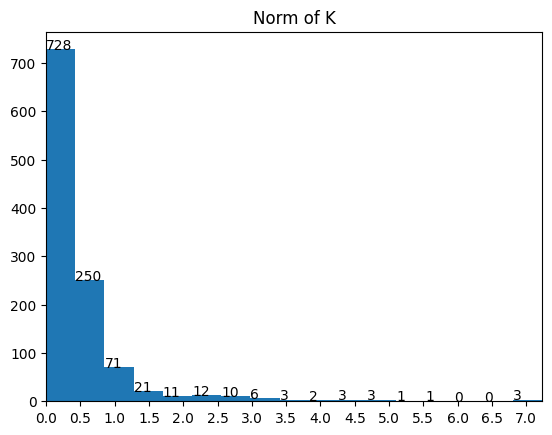

In [ ]:
# plt.plot(norm_diff, label='norm of K - LL.T')

arr = plt.hist(norm_K, bins=17)

for i in range(17):
    plt.text(arr[1][i], arr[0][i], str(int(arr[0][i])))

plt.title('Norm of K')
plt.xlim([0, max(norm_K)])
plt.xticks(np.arange(0, max(norm_K), 0.5))
plt.show()


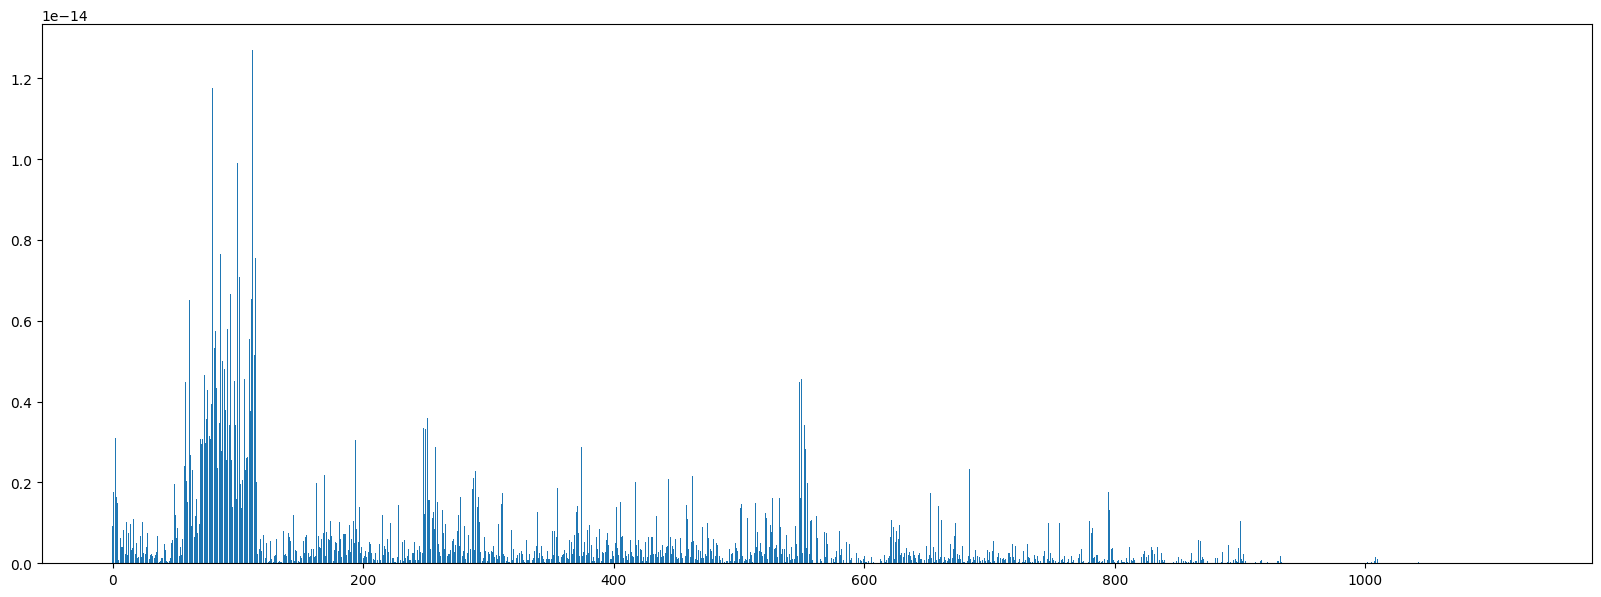

In [ ]:
check_dif = []

for K in real_K:
    # K = L @ L.T
    u, s, vh = np.linalg.svd(K)
    L = u @ np.sqrt(np.diag(s))
    check_dif.append(np.linalg.norm(K - L @ L.T, ord=2))
    # norm_K.append(np.linalg.norm(K , ord=2))
    # norm_LLT.append(np.linalg.norm(L @ L.T, ord=2))

fig = plt.subplots(figsize =(20, 7))
plt.bar(range(len(check_dif)), check_dif, label='Norm K - LL.T')
plt.show()

In [ ]:
max(check_dif), min(check_dif)

(1.2706134927202128e-14, 0.0)

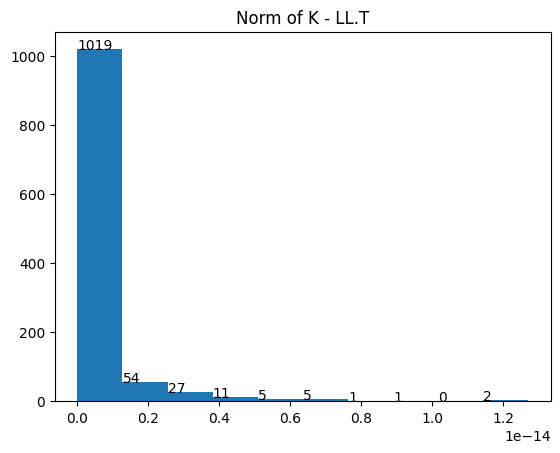

In [ ]:
arr = plt.hist(check_dif)

for i in range(10):
    plt.text(arr[1][i], arr[0][i], str(int(arr[0][i])))

plt.title('Norm of K - LL.T')
plt.show()


# MEALPY - Metaheuristic alg

In [ ]:
from mealpy.bio_based import SMA

sigma2 = 0.005807199353432736 / 1.662462247251338         # updated Forex data
sigma = np.round(np.sqrt(sigma2), 4)

def margine(vector_a, covariance_matrix, sigma2=sigma2):
      assets_number = len(vector_a)
      assert sigma2 > 0, "Required sigma2 > 0"
    #   print(np.shape(covariance_matrix), (assets_number, assets_number))
      assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
      return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2   # np.max(vector_a)**2

def obj_function(solution):
    def violate(value):
        return 0 if value <= 0 else value
    f_t = np.ones(len(solution))
    fx = f_t.T @ solution
    fx -= violate(margine(solution))
    return fx

tokenized_volume_meta = list()
margines = list()
tokenizations = list()
frac_tokenizations = list()
vol_A_meta = list()
vol_sum_A = list()

for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique())))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    # print(f'A shape: {A.shape}')
    K = np.zeros((table.shape[0], table.shape[0]))
    for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
        for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

    # sym
    K = 1/2*(K + K.T)
    # print(f'K shape : {K.shape}')

    def margine(vector_a, covariance_matrix=K, sigma2=sigma2):
      assets_number = len(vector_a)
      assert sigma2 > 0, "Required sigma2 > 0"
      assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
      return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2

    problem_dict = {
        "obj_func": obj_function,    # f_t.T @ solution
        "lb": [0 for x in range(A.shape[0])],
        "ub": list(A),
        "minmax": "max",
        "verbose": False,
    }

    model1 = SMA.BaseSMA(problem_dict, epoch=100, pop_size=100, pr=0.03)
    model1.solve()
    # print(f'sol : {model1.solution[0].shape}')
    # print(model1.solution[1])
    # print(model1.solution[2])

    tokenized_volume_meta.append(np.sum(model1.solution[0]))
    # print(tokenized_volume_meta)
    margines.append(margine(model1.solution[0], K, sigma2))
    tokenizations.append(model1.solution[0])
    vol_A_meta.append(A)
    frac = np.sum(model1.solution[0])/ np.sum(A)
    frac_tokenizations.append(frac)
    vol_sum_A.append(np.sum(A))


1125it [39:36,  2.11s/it]


In [ ]:
list_margine_in_range = []
list_idx = []
for i, margine in enumerate(margines):
    if margine <= 0:
        list_idx.append(i)
        list_margine_in_range.append(margine)

print(len(list_idx), len(list_margine_in_range))
len(list_margine_in_range)/1125

1117 1117


0.9928888888888889

In [ ]:
1125 - len(list_idx)

8

In [ ]:
[i for i in range(1125) if i not in list_idx]

[359, 385, 516, 600, 769, 879, 885, 1110]

In [ ]:
for i, margin in enumerate(margines):
    if margin > 0:
        print(margin)

19.22157415343681
0.00036405480932444334
31.41895864901521
4.144001406719719
0.09235287980850809
55.840522691476025
1.1162824729652128
77.24372505831488


Margines <= 0 : 99.29 %


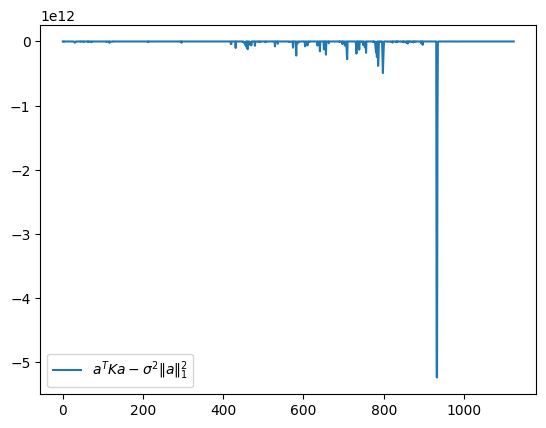

In [ ]:
print(f'Margines <= 0 : {round(len(list_margine_in_range)/1125 * 100, 2)} %')
plt.plot(margines, label=r'$a^TKa - \sigma^2 \|a\|_1^2$')
plt.legend()
plt.show()

Tokenized fraction:  0.6519320521059392
the number of fraction > 1: 0 numbers
----------
Tokenized fraction (metaheuristic avg filtered in range):  0.7295509892249874


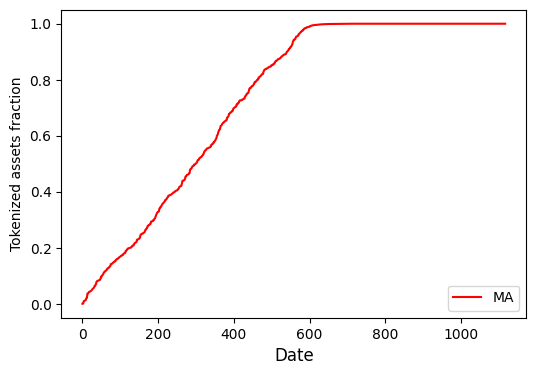

In [ ]:
liq_df_3 = liq_df2[liq_df2['timestamp'].isin(duration_date)]
time_tab = liq_df_3.groupby(by=liq_df_3['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

tokenizations_in_range = [tok for i, tok in enumerate(tokenizations) if i in list_idx]
frac_tokenizations_in_range = [frac for i, frac in enumerate(frac_tokenizations) if i in list_idx]
all_A = np.sum(list(time_tab['tab_at_mn']))

sumt = 0
for k in range(len(tokenizations_in_range)):
  sumt += np.sum(tokenizations_in_range[k])

print("Tokenized fraction: ", sumt / all_A)
# print("Tokenized fraction: ", np.sum(tokenized_volume_meta) / np.sum(vol_sum_A))
print(f"the number of fraction > 1: {len([x for x in frac_tokenizations_in_range if (x>1)])} numbers")

## metaheuristic
print('-' * 10)
print("Tokenized fraction (metaheuristic avg filtered in range): ", np.sum([x for x in frac_tokenizations_in_range if (x<=1)]) / len(frac_tokenizations))

####################################################################################################################################

fig = plt.figure(figsize=(6, 4))
plt.plot(np.sort([x for x in frac_tokenizations_in_range if (x<=1)]), 'r',label = "MA")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=10)
plt.legend(loc="lower right")
plt.show()

In [ ]:
0.65695 - 0.65167

0.005280000000000062

In [ ]:
min(frac_tokenizations_in_range), max(frac_tokenizations_in_range)

(0.0, 1.0)

Tokenized fraction:  0.6519393227567911
the number of fraction > 1: 0 numbers
----------
Tokenized fraction (metaheuristic avg - ALL):  0.7297084073082234


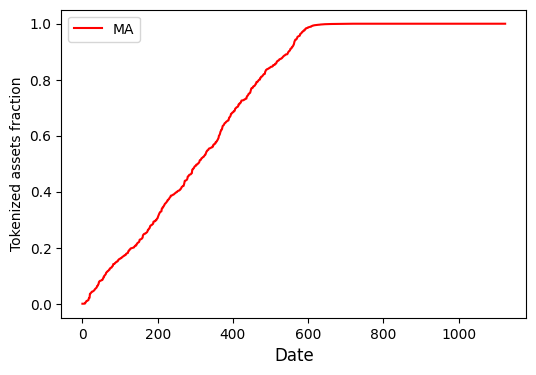

In [ ]:
liq_df_3 = liq_df2[liq_df2['timestamp'].isin(duration_date)]
time_tab = liq_df_3.groupby(by=liq_df_3['timestamp'])['tab_at_mn'].sum().reset_index().sort_values(by='timestamp')

sumt = 0
for k in range(len(tokenizations)):
  sumt += np.sum(tokenizations[k])

print("Tokenized fraction: ", sumt / np.sum(time_tab['tab_at_mn']))
print(f"the number of fraction > 1: {len([x for x in frac_tokenizations if (x>1)])} numbers")

## metaheuristic
print('-' * 10)
print("Tokenized fraction (metaheuristic avg - ALL): ", np.sum([x for x in frac_tokenizations if (x<=1)]) / len([x for x in frac_tokenizations if (x<=1)]))

####################################################################################################################################

fig = plt.figure(figsize=(6, 4))
plt.plot(np.sort([x for x in frac_tokenizations if (x<=1)]), 'r',label = "MA")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=10)
plt.legend()
plt.show()

# Summation

In [ ]:
[tok for i, tok in enumerate(frac_tokenizations) if tok==0]

[0.0, 0.0, 0.0]

In [ ]:
[i for i, tok in enumerate(frac_tokenizations) if tok==0]

[601, 889, 894]

In [ ]:
tokenizations[601]

array([0., 0.])

In [ ]:
tokenizations[889]

array([0.])

In [ ]:
tokenizations[894]

array([0.])

In [ ]:
idx_fail_const = [i for i in range(1125) if i not in list_idx]
idx_fail_const

[359, 385, 516, 600, 769, 879, 885, 1110]

In [ ]:
frac_tokenizations_adj = []
for i in range(len(frac_tokenizations)):
    if i in idx_fail_const:
        frac_tokenizations_adj.append(0)
    else:
        frac_tokenizations_adj.append(frac_tokenizations[i])

In [ ]:
1125 - len([tok for tok in frac_tokenizations_adj if tok == 0])

1114

In [ ]:
# tokenizations_in_range = [tok for i, tok in enumerate(tokenizations) if i in list_idx]
# frac_tokenizations_in_range = [frac for i, frac in enumerate(frac_tokenizations) if i in list_idx]

sumt_adj = 0
j = 0
for k in range(len(tokenizations)):
    if k not in idx_fail_const:
        j+= 1
        sumt_adj += np.sum(tokenizations[k])
print(j)
all_A = np.sum([A for i, A in enumerate(list(time_tab['tab_at_mn'])) if i in list_idx])

1117


Metaheuristic alg.
Tokenized fraction:  0.6521273715359434
Avg. fraction:  0.7295509892249874
SOCP
Tokenized fraction:  0.6569465817866758
Avg. fraction:  0.7326291934973336


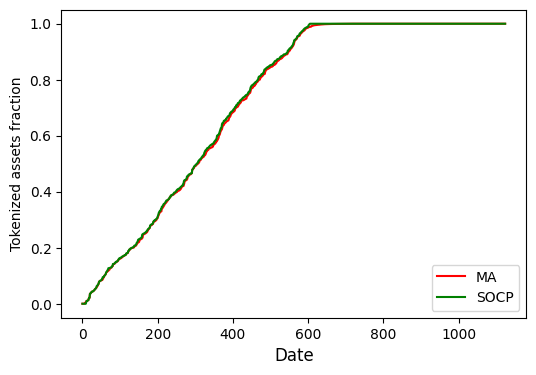

In [ ]:
print("Metaheuristic alg.")
print("Tokenized fraction: ", sumt_adj / all_A)
print("Avg. fraction: ", np.sum([x for x in frac_tokenizations_adj if (x<=1)]) / len([x for x in frac_tokenizations_adj if (x<=1)]))

print("SOCP")
print("Tokenized fraction: ", sumt_cvxpy / np.sum(time_tab['tab_at_mn']))
print("Avg. fraction: ", np.sum([x for x in frac_tokenizations_cvxpy if (x<=1)]) / len([x for x in frac_tokenizations_cvxpy if (x<=1)]))

fig = plt.figure(figsize=(6, 4))
plt.plot(np.sort([x for x in frac_tokenizations if (x<=1)]), 'r',label = "MA")
plt.plot(np.sort([x for x in frac_tokenizations_cvxpy if (x<=1)]), 'g',label = "SOCP")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tokenized assets fraction', fontsize=10)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# scatterplot

In [ ]:
[i for i, tok in enumerate(frac_tokenizations_cvxpy) if tok==0]

[]

In [ ]:
color_plot = []
count_cvxpy_better = 0

for i in range(len(frac_tokenizations_cvxpy)):
    if frac_tokenizations_cvxpy[i] > frac_tokenizations_adj[i]:
        count_cvxpy_better += 1
        color_plot.append('g')
    else:
        color_plot.append('r')

SOCP is better than Metaheuristic alg.: 56.18 %


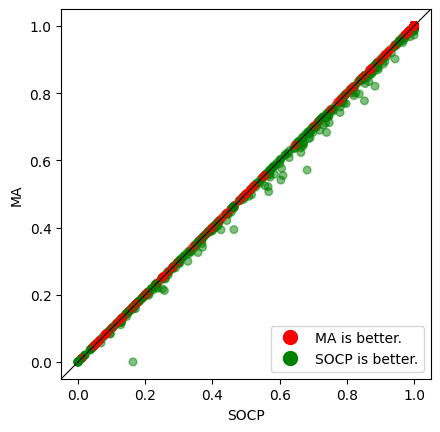

In [ ]:
print(f'SOCP is better than Metaheuristic alg.: {round(count_cvxpy_better/len(frac_tokenizations_cvxpy)*100, 2)} %')

fig, ax = plt.subplots()
scatter = ax.scatter(frac_tokenizations_cvxpy, frac_tokenizations_adj, c=color_plot, s=30, alpha=0.5)

red_dot, = ax.plot([], [], "ro", markersize=10)
green_dot, = ax.plot([], [], "go", markersize=10)
ax.legend([red_dot, green_dot], ["MA is better.", "SOCP is better."], loc="lower right")

plt.axline((0, 0), (1, 1), linewidth=0.8, color='black')
plt.xlabel('SOCP', fontsize=10)
plt.ylabel('MA', fontsize=10)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

# Test sigma - SOCP

In [ ]:
import cvxpy.atoms.norm as norm

# All timestamps
duration_date = sorted(list(liq_df2['timestamp'].unique()))
print(f'All days = {len(duration_date)} \nfrom {min(duration_date)} to {max(duration_date)}')

All days = 1125 
from 2019-11-18T00:00:00.000000000 to 2023-03-30T00:00:00.000000000


In [ ]:
real_K = []
max_cov = []
min_cov = []

for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
    table = liq_df2[liq_df2["timestamp"] == day_idx]
    A = np.array(table['tab_at_mn'])
    K = np.zeros((table.shape[0], table.shape[0]))
    for i, (p_A, x_A) in enumerate(zip(list(table['psi']), list(table['x_min']))):
        for j, (p_B, x_B) in enumerate(zip(list(table['psi']), list(table['x_min']))):
            K[i, j] = p_B * (1 - p_A) if x_A > x_B else p_A * (1 - p_B)

    # symmetric covariance
    K = 1/2 * (K + K.T)
    real_K.append(K)

    max_cov.append(np.max(K))
    min_cov = []
    for row in K:
        min_cov_i = np.min([K[k] for k in range(len(K))])
        min_cov.append(min_cov_i)
    min_cov.append(np.min(min_cov))

max_cov_all = np.max(max_cov)
min_cov_all = np.min(min_cov)

print(round(min_cov_all, 4), round(max_cov_all, 4))

1125it [00:03, 315.74it/s]

0.0 0.25


(array([279.,  21.,  27.,  20.,  22.,  39.,  39.,  69.,  82., 527.]),
 array([0.        , 0.02499999, 0.04999998, 0.07499996, 0.09999995,
        0.12499994, 0.14999993, 0.17499991, 0.1999999 , 0.22499989,
        0.24999988]),
 <BarContainer object of 10 artists>)

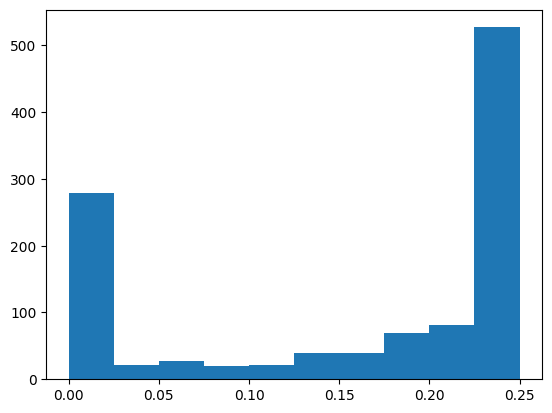

In [ ]:
plt.hist(max_cov)

[5.505824869948231e-76, 5.505824869948231e-76, 5.505824869948231e-76]


(array([0., 0., 0., 0., 0., 3., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

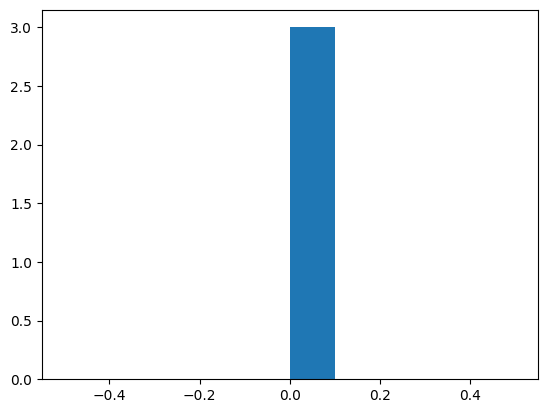

In [ ]:
print(min_cov)
plt.hist(min_cov)

In [ ]:
sigma2_list_opt = [0.0028, 0.0050, 0.0074, 0.0092, 0.0125, 0.0147, 0.0174, 0.0200, 0.0223,
                   0.025, 0.050, 0.07398, 0.100, 0.1249, 0.149, 0.175, 0.200 , 0.225, 0.250]

plot_fraction = []
plot_fraction_pure = []
plot_prob_const = []

for considered_sig in sigma2_list_opt:
    sigma2 = round(considered_sig, 4)
    sigma = np.round(np.sqrt(sigma2), 4)

    tokenized_volume_meta_cvxpy, margines_cvxpy, tokenizations_cvxpy, frac_tokenizations_cvxpy, vol_A_meta_cvxpy, vol_sum_A_cvxpy = [], [], [], [], [], []
    norm_diff, norm_K, norm_LLT, real_K = [], [], [], []

    def margine(vector_a, covariance_matrix, sigma2=sigma2):
        assets_number = len(vector_a)
        assert sigma2 > 0, "Required sigma2 > 0"
        assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
        return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2

    for ii, day_idx in tqdm(enumerate(sorted(duration_date))):
        table = liq_df2[liq_df2["timestamp"] == day_idx]
        A = np.array(table['tab_at_mn'])
        K = np.zeros((table.shape[0], table.shape[0]))
        for i, (p_A, x_A) in enumerate(zip(list(table['psi']), list(table['x_min']))):
            for j, (p_B, x_B) in enumerate(zip(list(table['psi']), list(table['x_min']))):
                K[i, j] = p_B * (1 - p_A) if x_A > x_B else p_A * (1 - p_B)

        # symmetric covariance
        K = 1/2 * (K + K.T)
        real_K.append(K)

        # K = L @ L.T
        u, s, vh = np.linalg.svd(K)
        L = u @ np.sqrt(np.diag(s))
        norm_diff.append(np.linalg.norm(K - L @ L.T, ord=2))
        norm_K.append(np.linalg.norm(K , ord=2))
        norm_LLT.append(np.linalg.norm(L @ L.T, ord=2))

        a = cp.Variable(K.shape[0])
        f_t = np.ones(K.shape[0])
        zero_cond = np.zeros(K.shape[0]).T

        objective = cp.Minimize(-f_t.T @ a)
        soc_constraints = [ cp.SOC( sigma*(f_t.T @ a) , L.T @ a ) ]
        prob = cp.Problem(objective,
                        soc_constraints + [norm(L.T @ a, 2) - sigma*(f_t.T @ a) <= 0] + [ a >= zero_cond ] + [ a <= A ] )
        prob.solve(feastol=1e-36)

        tokenized_volume_meta_cvxpy.append(np.sum(a.value))
        margines_cvxpy.append(margine(a.value, K, sigma2))
        tokenizations_cvxpy.append(a.value)

        vol_A_meta_cvxpy.append(A)
        vol_sum_A_cvxpy.append(np.sum(A))

        frac_cvxpy = np.sum(a.value)/ np.sum(A)
        frac_tokenizations_cvxpy.append(frac_cvxpy)

    prob_fraction = []
    for i, margin in enumerate(margines_cvxpy):
        if (margin > 0) & (margin > np.finfo(float).eps):
            prob_fraction.append(i)

    frac_no_violate = np.sum([tok for i, tok in enumerate(tokenized_volume_meta_cvxpy) if i not in prob_fraction]) / np.sum(vol_sum_A_cvxpy)
    frac_pure = np.sum(tokenized_volume_meta_cvxpy) / np.sum(vol_sum_A_cvxpy)

    plot_fraction.append(frac_no_violate)
    plot_fraction_pure.append(frac_pure)
    plot_prob_const.append(len(prob_fraction))

    print(f'sigma2: {sigma2}, sigma: {sigma}')
    print(f'problem: {len(sorted(prob_fraction))}')
    print(f'Tokenized fraction: {frac_pure}, no violation: {frac_no_violate} \n')

1125it [00:42, 26.31it/s]


sigma2: 0.0028, sigma: 0.0529
problem: 0
Tokenized fraction: 0.6454234812377397, no violation: 0.6454234812377397 



1125it [00:43, 26.08it/s]


sigma2: 0.005, sigma: 0.0707
problem: 0
Tokenized fraction: 0.680663215018536, no violation: 0.680663215018536 



1125it [00:44, 25.17it/s]


sigma2: 0.0074, sigma: 0.086
problem: 0
Tokenized fraction: 0.7080503851603515, no violation: 0.7080503851603515 



1125it [00:43, 25.99it/s]


sigma2: 0.0092, sigma: 0.0959
problem: 0
Tokenized fraction: 0.7240902876897118, no violation: 0.7240902876897118 



1125it [00:44, 25.56it/s]


sigma2: 0.0125, sigma: 0.1118
problem: 0
Tokenized fraction: 0.7484046558986946, no violation: 0.7484046558986946 



1125it [00:44, 25.30it/s]


sigma2: 0.0147, sigma: 0.1212
problem: 0
Tokenized fraction: 0.7620604435300693, no violation: 0.7620604435300693 



1125it [00:46, 24.13it/s]


sigma2: 0.0174, sigma: 0.1319
problem: 0
Tokenized fraction: 0.7758067198356613, no violation: 0.7758067198356613 



1125it [00:46, 24.25it/s]


sigma2: 0.02, sigma: 0.1414
problem: 0
Tokenized fraction: 0.7882948969951222, no violation: 0.7882948969951222 



1125it [00:53, 21.09it/s]


sigma2: 0.0223, sigma: 0.1493
problem: 0
Tokenized fraction: 0.7992919584870883, no violation: 0.7992919584870883 



1125it [00:54, 20.63it/s]


sigma2: 0.025, sigma: 0.1581
problem: 0
Tokenized fraction: 0.8113899299498487, no violation: 0.8113899299498487 



1125it [01:18, 14.42it/s]


sigma2: 0.05, sigma: 0.2236
problem: 0
Tokenized fraction: 0.8825930407313561, no violation: 0.8825930407313561 



1125it [01:16, 14.71it/s]


sigma2: 0.074, sigma: 0.272
problem: 0
Tokenized fraction: 0.9250362559727368, no violation: 0.9250362559727368 



1125it [01:18, 14.27it/s]


sigma2: 0.1, sigma: 0.3162
problem: 0
Tokenized fraction: 0.9530710349693614, no violation: 0.9530710349693614 



1125it [01:49, 10.28it/s]


sigma2: 0.1249, sigma: 0.3534
problem: 0
Tokenized fraction: 0.9670883919481369, no violation: 0.9670883919481369 



1125it [01:32, 12.17it/s]


sigma2: 0.149, sigma: 0.386
problem: 0
Tokenized fraction: 0.9771953159850342, no violation: 0.9771953159850342 



1125it [01:33, 12.08it/s]


sigma2: 0.175, sigma: 0.4183
problem: 0
Tokenized fraction: 0.9865004743453886, no violation: 0.9865004743453886 



1125it [01:24, 13.25it/s]


sigma2: 0.2, sigma: 0.4472
problem: 0
Tokenized fraction: 0.994943384903771, no violation: 0.994943384903771 



1125it [01:34, 11.95it/s]


sigma2: 0.225, sigma: 0.4743
problem: 0
Tokenized fraction: 0.9996638476080667, no violation: 0.9996638476080667 



1125it [01:11, 15.72it/s]

sigma2: 0.25, sigma: 0.5
problem: 0
Tokenized fraction: 0.9999999999999899, no violation: 0.9999999999999899 



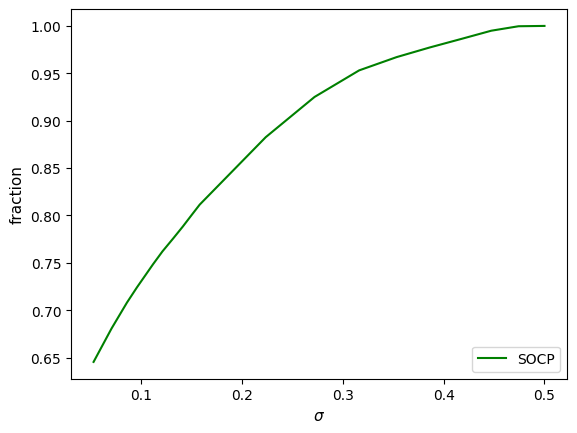

In [17]:
plot_fraction_SOCP_list = [0.6454234812377397, 0.680663215018536, 0.7080503851603515, 0.7240902876897118, 0.7484046558986946,
                           0.7620604435300693, 0.7758067198356613, 0.7882948969951222, 0.7992919584870883, 0.8113899299498487,
                           0.8825930407313561, 0.9250362559727368, 0.9530710349693614, 0.9670883919481369, 0.9771953159850342,
                           0.9865004743453886, 0.994943384903771, 0.9996638476080667, 0.9999999999999899 ]

sigma2_list_opt = [0.0028, 0.0050, 0.0074, 0.0092, 0.0125, 0.0147, 0.0174, 0.0200, 0.0223,
                   0.025, 0.050, 0.07398, 0.100, 0.1249, 0.149, 0.175, 0.200 , 0.225, 0.250]
sigma_list = [round(np.sqrt(sigma),4) for sigma in sigma2_list_opt]

plt.plot(sigma_list, plot_fraction_SOCP_list, label="SOCP", color='g')
plt.xlabel(r"$\sigma$", fontsize=11)
plt.ylabel('fraction', fontsize=11)
plt.legend(loc="lower right")
plt.show()

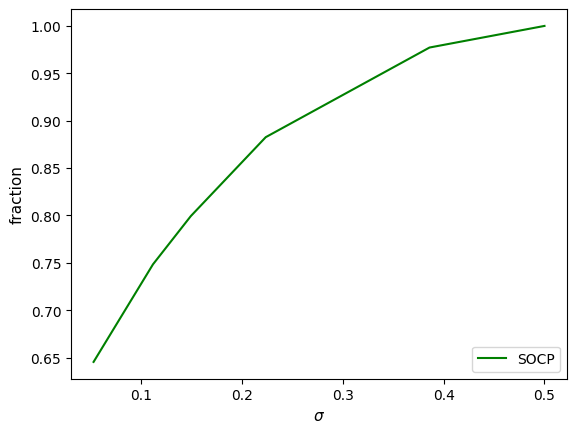

In [18]:
sigma2_list_opt = [0.0028, 0.0125, 0.0223,
                   0.050, 0.149, 0.250]
sigma_list = [round(np.sqrt(sigma),4) for sigma in sigma2_list_opt]

plot_fraction_pure_SOCP = [0.6454234812377397, 0.7484046558986946, 0.7992919584870883,
                           0.8825930407313561, 0.9771953159850342, 0.9999999999999899 ]

plt.plot(sigma_list, plot_fraction_pure_SOCP, label="SOCP", color='g')

plt.xlabel(r"$\sigma$", fontsize=11)
plt.ylabel('fraction', fontsize=11)
plt.legend(loc="lower right")
plt.show()

# Test sigma - MA

In [ ]:
from mealpy.bio_based import SMA
import cvxpy.atoms.norm as norm

sigma2_list_opt = [0.0028, 0.0125, 0.0223,
                   0.050, 0.149, 0.250]

plot_fraction_MA = []
plot_fraction_pure_MA = []
plot_prob_const_MA = []

for considered_sig in sigma2_list_opt:
    sigma2 = round(considered_sig, 4)
    sigma = np.round(np.sqrt(sigma2), 4)

    def margine(vector_a, covariance_matrix, sigma2=sigma2):
        assets_number = len(vector_a)
        assert sigma2 > 0, "Required sigma2 > 0"
        #   print(np.shape(covariance_matrix), (assets_number, assets_number))
        assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
        return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2   # np.max(vector_a)**2

    def obj_function(solution):
        def violate(value):
            return 0 if value <= 0 else value
        f_t = np.ones(len(solution))
        fx = f_t.T @ solution
        fx -= violate(margine(solution))
        return fx

    tokenized_volume_meta, margines, tokenizations, frac_tokenizations, vol_A_meta, vol_sum_A = [], [], [], [], [], []

    for ii, day_idx in tqdm(enumerate(sorted(list(liq_df2['timestamp'].unique())))):
        table = liq_df2[liq_df2["timestamp"] == day_idx]
        A = np.array(table['tab_at_mn'])
        # print(f'A shape: {A.shape}')
        K = np.zeros((table.shape[0], table.shape[0]))
        for i,(p_A,x_A) in enumerate(zip(list(table['psi']),list(table['x_min']))):
            for j,(p_B,x_B) in enumerate(zip(list(table['psi']),list(table['x_min']))):
                K[i,j] = p_B * (1-p_A) if x_A > x_B else p_A * (1-p_B)

        # sym
        K = 1/2*(K + K.T)
        # print(f'K shape : {K.shape}')

        def margine(vector_a, covariance_matrix=K, sigma2=sigma2):
            assets_number = len(vector_a)
            assert sigma2 > 0, "Required sigma2 > 0"
            assert np.shape(covariance_matrix) == (assets_number, assets_number), "Cov matrix should be assets_number X assets_number"
            return np.matmul(np.matmul(vector_a, covariance_matrix), vector_a) - sigma2 * np.linalg.norm((vector_a), ord=1)**2

        problem_dict = {
            "obj_func": obj_function,    # f_t.T @ solution
            "lb": [0 for x in range(A.shape[0])],
            "ub": list(A),
            "minmax": "max",
            "verbose": False,
        }

        model1 = SMA.BaseSMA(problem_dict, epoch=100, pop_size=100, pr=0.03)
        model1.solve()

        tokenized_volume_meta.append(np.sum(model1.solution[0]))
        margines.append(margine(model1.solution[0], K, sigma2))
        tokenizations.append(model1.solution[0])
        vol_A_meta.append(A)
        frac = np.sum(model1.solution[0])/ np.sum(A)
        frac_tokenizations.append(frac)
        vol_sum_A.append(np.sum(A))

    prob_fraction = []
    for i, margin in enumerate(margines):
        if (margin > 0) & (margin > np.finfo(float).eps):
            prob_fraction.append(i)

    frac_no_violate = np.sum([tok for i, tok in enumerate(tokenized_volume_meta) if i not in prob_fraction]) / np.sum(vol_sum_A)
    frac_pure = np.sum(tokenized_volume_meta) / np.sum(vol_sum_A)

    plot_fraction_MA.append(frac_no_violate)
    plot_fraction_pure_MA.append(frac_pure)
    plot_prob_const_MA.append(len(prob_fraction))

    print(f'sigma2: {sigma2}, sigma: {sigma}')
    print(f'problem: {len(sorted(prob_fraction))}')
    print(f'Tokenized fraction: {frac_pure}, no violation: {frac_no_violate} \n')


1125it [36:35,  1.95s/it]


sigma2: 0.0028, sigma: 0.0529
problem: 6
Tokenized fraction: 0.6406732112139931, no violation: 0.6406730254633228 



1125it [36:04,  1.92s/it]


sigma2: 0.0125, sigma: 0.1118
problem: 4
Tokenized fraction: 0.7435493715813943, no violation: 0.7435492786582076 



1125it [35:58,  1.92s/it]


sigma2: 0.0223, sigma: 0.1493
problem: 2
Tokenized fraction: 0.7947902784478462, no violation: 0.7947902356281367 



1125it [36:23,  1.94s/it]


sigma2: 0.05, sigma: 0.2236
problem: 0
Tokenized fraction: 0.878570922800574, no violation: 0.878570922800574 



1125it [36:10,  1.93s/it]


sigma2: 0.149, sigma: 0.386
problem: 0
Tokenized fraction: 0.97445223986484, no violation: 0.97445223986484 



1125it [36:12,  1.93s/it]

sigma2: 0.25, sigma: 0.5
problem: 0
Tokenized fraction: 0.9975245526406209, no violation: 0.9975245526406209 



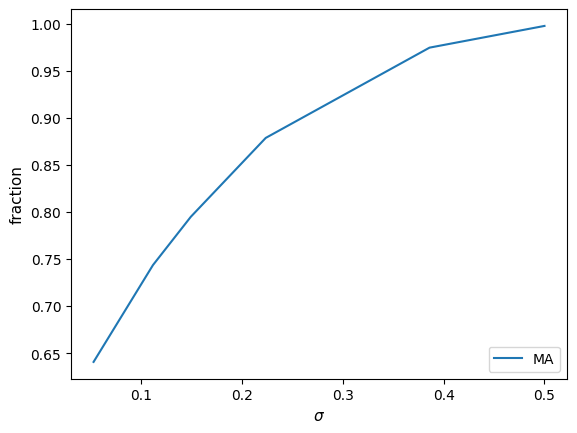

In [ ]:
sigma_list = [round(np.sqrt(sigma),4) for sigma in sigma2_list_opt]

plt.plot(sigma_list, plot_fraction_MA, label="MA")
plt.xlabel(r"$\sigma$", fontsize=11)
plt.ylabel('fraction', fontsize=11)
plt.legend(loc="lower right")
plt.show()

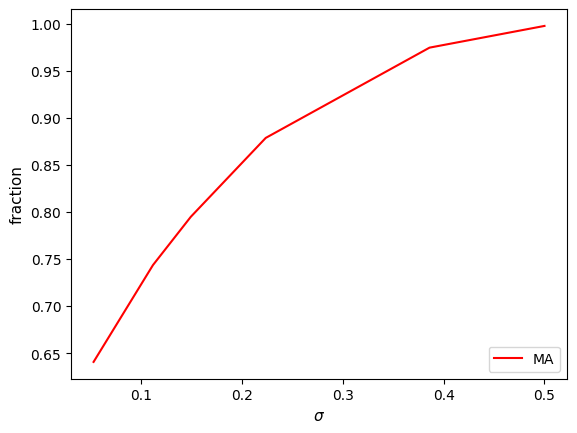

In [20]:
plot_fraction_MA = [0.6406730254633228, 0.7435492786582076, 0.7947902356281367,
                    0.878570922800574, 0.97445223986484, 0.9975245526406209]

sigma2_list_opt = [0.0028, 0.0125, 0.0223,
                   0.050, 0.149, 0.250]
sigma_list = [round(np.sqrt(sigma),4) for sigma in sigma2_list_opt]

plt.plot(sigma_list, plot_fraction_MA, label="MA", color='r')
plt.xlabel(r"$\sigma$", fontsize=11)
plt.ylabel('fraction', fontsize=11)
plt.legend(loc="lower right")
plt.show()

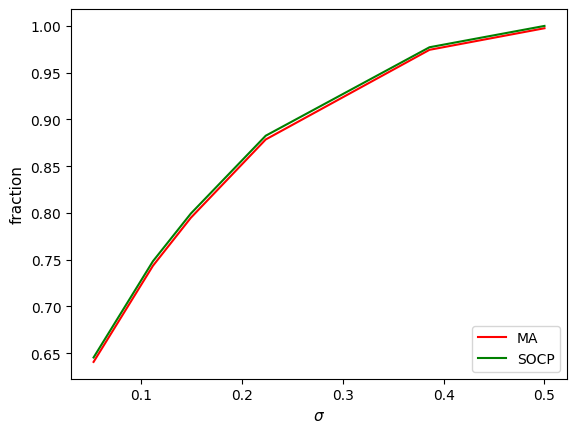

In [21]:
sigma2_list_opt = [0.0028, 0.0125, 0.0223,
                   0.050, 0.149, 0.250]
sigma_list = [round(np.sqrt(sigma),4) for sigma in sigma2_list_opt]

plot_fraction_pure_SOCP = [0.6454234812377397, 0.7484046558986946, 0.7992919584870883,
                           0.8825930407313561, 0.9771953159850342, 0.9999999999999899 ]

plot_fraction_MA = [0.6406730254633228, 0.7435492786582076, 0.7947902356281367,
                    0.878570922800574, 0.97445223986484, 0.9975245526406209]

plt.plot(sigma_list, plot_fraction_MA, label="MA", color='r')
plt.plot(sigma_list, plot_fraction_pure_SOCP, label="SOCP", color='g')

plt.xlabel(r"$\sigma$", fontsize=11)
plt.ylabel('fraction', fontsize=11)
plt.legend(loc="lower right")
plt.show()